# Intro
- Code to estimate Gaussians of images 600 to 800 in the database

In [1]:
!pip install -q ultralytics==8.0.154

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.0/613.0 kB 8.4 MB/s eta 0:00:00


In [2]:
!pip install -q adjustText==0.8

In [3]:
!pip install -q plotly==5.15.0

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import inspect

In [6]:
import os
import random
import shutil
import pandas as pd
import numpy as np

from datetime import datetime

In [7]:
from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
import scipy.stats as stats
import scipy.io
from scipy.optimize import linear_sum_assignment

from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from skimage.feature import peak_local_max
import skimage.color
import skimage.filters

In [8]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from adjustText import adjust_text
import plotly.graph_objects as go

In [9]:
from ultralytics import YOLO

In [10]:
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

In [11]:
from ultralytics.utils import plotting

In [12]:
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/")

['run_estimation_4.ipynb',
 'Data',
 'image_preprocessors.ipynb',
 'image_extractors.ipynb',
 'Models',
 'transforms.ipynb',
 'Results',
 'experimentation.ipynb',
 'yolo_labelling.ipynb',
 'archived_code.ipynb',
 'pipelines.ipynb',
 'error_estimation.ipynb',
 'auxiliary_functions.ipynb',
 'gaussian_generator.ipynb',
 'Draws',
 'gaussian_estimation.ipynb',
 'data_analysis.ipynb',
 'aux_plotter.ipynb',
 'predict_T80Kenji.ipynb',
 'run_estimation_1.ipynb',
 'run_estimation_12.ipynb',
 'run_estimation_2.ipynb',
 'run_estimation_3.ipynb']

# Load modules

In [13]:
# Load some modulus
# Auxiliary functions in computation and plotting
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/auxiliary_functions.ipynb"
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/aux_plotter.ipynb"

# Pipelines contain steps of the analysis from the "initial" data to the final result
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/pipelines.ipynb"

# Transforms contain the transformations of the image (example laplacian)
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/transforms.ipynb"

# Image extractors
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/image_extractors.ipynb"

# Dist generation
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/gaussian_generator.ipynb"

# Dist estimation
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/gaussian_estimation.ipynb"

# Yolo labelling
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/yolo_labelling.ipynb"

# Error estimation
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/error_estimation.ipynb"

In [14]:
print(inspect.getsource(ppl_fit_gaussians))

    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time} seconds")
        return result



# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [15]:
# Load 800 gaussians
mat = scipy.io.loadmat('/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/db_80beam.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [16]:
# Generate GRID
width = 0.143
length = 0.377
x, y = generate_grid((0, width), (0, length), 143, 377)

## Box of the gaussians - using dispersion_x and dispersion_y (from true parameters)

In [ ]:
# Load data
n_image = 609
labels_type = "Labelsv0_detect"
task = "detect"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Structure covariances
covariances = [np.diag(cov) for cov in zip((dispersion_x/np.sqrt(2))**2, (dispersion_y/np.sqrt(2))**2)]

Number of indentifiable Gaussians (center in the image): 77


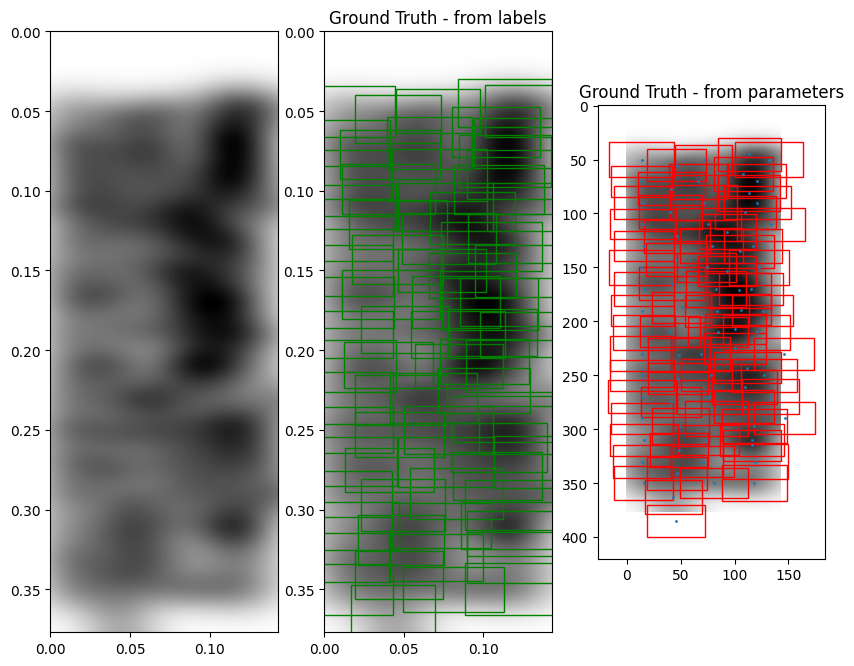

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize = (10, 10))

# Display the image
axs[2].imshow(im)
plot_boxes_gmm(means = list(zip(xs, ys)),
               covariances = covariances,
               ax = axs[2],
               beta = 3)
axs[2].set_title("Ground Truth - from parameters")
axs[2].scatter(xs * 1000, ys * 1000, s = 1)

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = task,
                   colorbar = False)
axs[1].set_title("Ground Truth - from labels")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

# [ESTIMATION PART IV]
- Images: 400 - 599
  -  All amplitudes are higher around 2.1E6 (400%)
  - x center coincides with beta xs
  - y center Coincides with beta ys
  - dispersion in x Higher dispersion in x direction around 0.017 (170%)
  - dispersion in y Higher dispersion in y direction around 0.01 (170%)


## [ESTIMATION] Pipeline ppl_SCIKIT_GMM
- Processing using Scikit-image library
- Mean and covariances from GMM

In [17]:
# Load data
n_image = 601

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

### Centers estimation

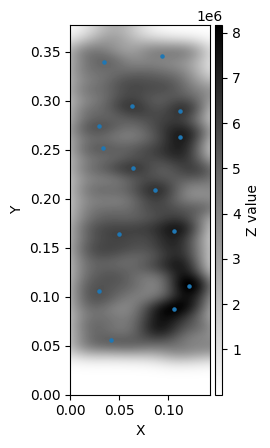

In [18]:
# Find local maxima coordinates
coordinates = peak_local_max(image[2], min_distance = 1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s = 5)

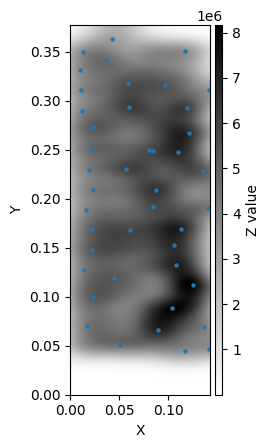

In [19]:
# Find local maxima coordinates
z_laplace = laplace(image[2])
z_laplace[np.nonzero(z_laplace >= 0)] = 0
coordinates = peak_local_max(-1 * z_laplace, min_distance = 1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s = 5)

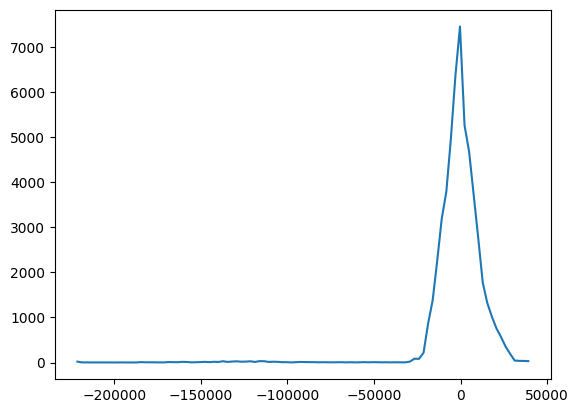

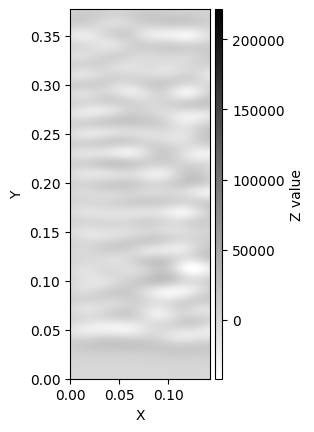

In [20]:
# Thresholding laplacian
# histogram of values
histogram, bin_edges = np.histogram(-1 * laplace(image[2]), bins = 100)

fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)

fig, ax = plt.subplots()
plot_grayscale(x, y, laplace(image[2]), ax)

estimate_parameters_gmm executed in 5.294665336608887 seconds
ppl_fit_gaussians executed in 5.820713758468628 seconds


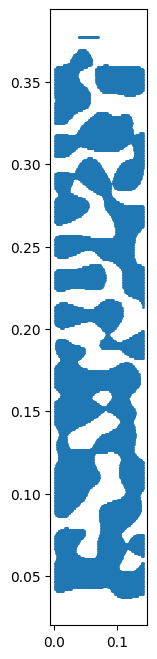

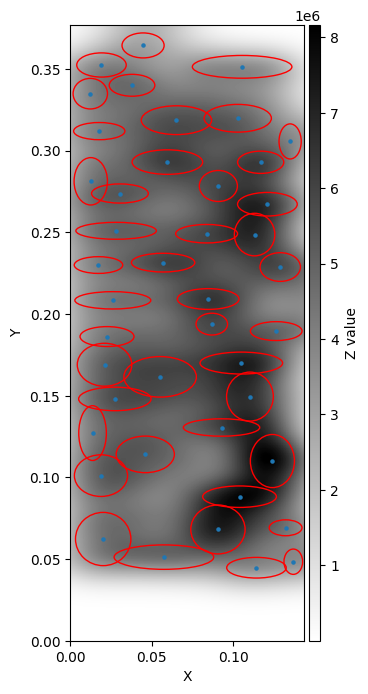

In [21]:
# Estimate Gaussian - Final prediction
(means,
 covariances,
 angles,
 amplitudes) = ppl_fit_gaussians(image,
                                 means_init = 'laplace',
                                 peak_method = 'laplace',
                                 em_iterations = 1000,
                                 covariance_gaussians_type = 'diag',
                                 n_gaussians = None,
                                 image_ranges = [(0, 0.143), (0, 0.377)],
                                 image_size = [143, 377],
                                 fig_size = (10, 8),
                                 plot = True,
                                 plot_points = True)

In [22]:
labels_type = "Labelsv0_detect"
task = "detect"
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

Number of indentifiable Gaussians (center in the image): 76


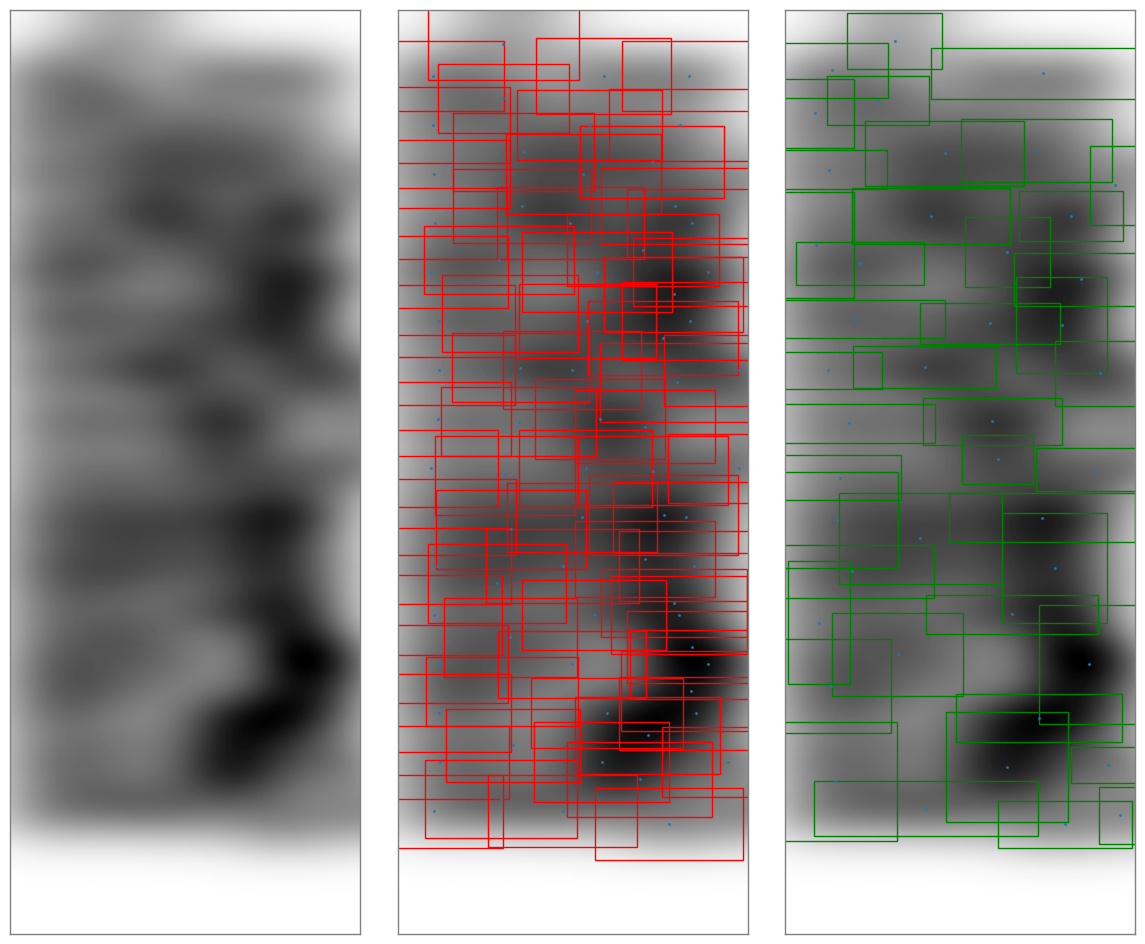

In [23]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize = (15, 12))

# Display the image and plot predicted centers
axs[2].imshow(im)
plot_boxes_gmm(means = means,
               covariances = covariances,
               ax = axs[2],
               beta = 3,
               edge_color = 'g')
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:,0] * 1000, means[:, 1] * 1000, s = 1)
# axs[2].axis('off')
axs[2].set_xlim(0, 143)
axs[2].set_ylim(0, 377)

#axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = task,
                   colorbar = False,
                   plot_centers = True)
# axs[1].axis('off')
axs[1].set_xlim(0, 0.143)
axs[1].set_ylim(0, 0.377)
#axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, 0.143)
axs[0].set_ylim(0, 0.377)


for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

  ax.set_xticks([])
  ax.set_yticks([])
  # Change the color of the axis spines (borders)
  for spine in ax.spines.values():
      spine.set_edgecolor('gray')
      spine.set_linewidth(1)

plt.subplots_adjust(wspace= 0)
plt.show()

### Error evaluation
- Dispersion_x in the mat file is equal to sqrt(2) * sigma_x, same for y direction

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[738, 777, 650, 772, 703, 704, 726, 710, 601, 622, 664, 694, 690, 700, 605, 719, 614, 603, 766, 714]


In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - gmm' : [],
           'Number identifiable - gmm' : [],
           'Percentage - gmm' : [],
           'RMSE_cx - gmm' : [],
           'RMSE_cy - gmm' : [],
           'RMSE_c - gmm' : [],
           'RMSE_sigmax - gmm' : [],
           'RMSE_sigmay - gmm' : [],
           'RMSE_sigma - gmm' : [],
           'RMSE_amplitude - gmm': [],
           'MaxE_sigmax - gmm': [],
           'MaxE_sigmay - gmm': [],
           'MaxE_sigma - gmm': [],
           'RMSE_amplitude - gmm': [],
           'RMSEPixel - gmm': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       peak_method = 'laplace',
                                       estimation_method = "gmm",
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]

estimate_parameters_gmm executed in 2.0332608222961426 seconds
ppl_fit_gaussians executed in 2.061185598373413 seconds
covariances [[[0.02651083 0.        ]
  [0.         0.00659401]]]
covariances true [[[0.02510648 0.        ]
  [0.         0.0138926 ]]]
estimate_parameters_gmm executed in 2.661756992340088 seconds
ppl_fit_gaussians executed in 2.674081802368164 seconds
covariances [[[0.02402768 0.        ]
  [0.         0.00702851]]]
covariances true [[[0.02541002 0.        ]
  [0.         0.01341907]]]
estimate_parameters_gmm executed in 5.124617099761963 seconds
ppl_fit_gaussians executed in 5.1583168506622314 seconds
covariances [[[0.02228426 0.        ]
  [0.         0.00851676]]]
covariances true [[[0.02874664 0.        ]
  [0.         0.01516224]]]
estimate_parameters_gmm executed in 5.335970878601074 seconds
ppl_fit_gaussians executed in 5.369339942932129 seconds
covariances [[[0.02358087 0.        ]
  [0.         0.00766723]]]
covariances true [[[0.02922224 0.        ]
  [0. 

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean       std         max
Image                          688.60     56.81      777.00
Number identified - gmm         43.10      2.55       48.00
Number identifiable - gmm       75.30      1.42       77.00
Percentage - gmm                57.27      3.71       64.86
RMSE_cx - gmm                   13.29      2.28       17.01
RMSE_cy - gmm                    2.30      0.34        3.06
RMSE_c - gmm                    13.50      2.24       17.18
RMSE_sigmax - gmm               41.66      2.08       46.72
RMSE_sigmay - gmm               41.76      3.23       48.50
RMSE_sigma - gmm                59.06      2.49       62.77
RMSE_amplitude - gmm            91.87      4.29      100.65
MaxE_sigmax - gmm               85.64      4.50       94.38
MaxE_sigmay - gmm               98.32     37.35      178.08
MaxE_sigma - gmm               132.16     30.43      198.79
RMSEPixel - gmm            1199737.96  34241.47  1255833.15

In [ ]:
pd.DataFrame.from_dict(results).round(2)

Image  Number identified - gmm  Number identifiable - gmm  \
0     738                       47                         77   
1     777                       45                         77   
2     650                       48                         74   
3     772                       43                         73   
4     703                       44                         74   
5     704                       43                         74   
6     726                       42                         76   
7     710                       39                         74   
8     601                       43                         76   
9     622                       39                         76   
10    664                       46                         73   
11    694                       43                         74   
12    690                       45                         75   
13    700                       40                         77   
14    605                       41                         76   
15    719                       42                         76   
16    614                       40                         77   
17    603                       46                         77   
18    766                       43                         74   
19    714                       43                         76   

    Percentage - gmm  RMSE_cx - gmm  RMSE_cy - gmm  RMSE_c - gmm  \
0              61.04          14.05           2.33         14.24   
1              58.44          14.59           1.83         14.70   
2              64.86          10.61           2.05         10.80   
3              58.90          16.18           2.07         16.31   
4              59.46          14.39           2.26         14.56   
5              58.11           9.24           2.50          9.58   
6              55.26          12.23           2.04         12.40   
7              52.70          13.47           2.16         13.65   
8              56.58          15.86           1.77         15.96   
9              51.32           9.47           1.89          9.66   
10             63.01          11.89           2.07         12.07   
11             58.11          17.01           2.38         17.18   
12             60.00          12.92           2.41         13.14   
13             51.95          13.08           2.22         13.26   
14             53.95          14.89           2.16         15.04   
15             55.26          11.60           2.67         11.90   
16             51.95          11.16           2.77         11.50   
17             59.74          16.72           3.06         17.00   
18             58.11          12.05           2.70         12.35   
19             56.58          14.48           2.58         14.71   

    RMSE_sigmax - gmm  RMSE_sigmay - gmm  RMSE_sigma - gmm  \
0               40.06              38.86             55.81   
1               39.52              48.50             62.56   
2               41.93              41.45             58.96   
3               40.85              45.26             60.97   
4               39.67              41.23             57.21   
5               40.87              42.80             59.18   
6               39.67              47.12             61.60   
7               40.96              36.70             55.00   
8               39.46              41.11             56.98   
9               42.49              39.72             58.16   
10              42.46              46.11             62.68   
11              40.11              43.22             58.96   
12              46.72              38.41             60.48   
13              42.34              39.99             58.24   
14              38.80              38.27             54.50   
15              44.52              44.24             62.77   
16              43.64              38.31             58.07   
17              44.63              41.32             60.82   
18              41.54          

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {"GMM - random state 13 - first 200 images"}\n
                 id_images evaluated: {eval_images}""",
                 name = "E4GMM")

#### Total error

In [ ]:
# Computing error
gaussians = list(zip(means, covariances, amplitudes))

# Generate image from Gaussians and compute MSE
generated_image = sum_gaussians(x, y, gaussians)
mse = compute_mse(image[2], generated_image)

## [ESTIMATION] Pipeline ppl_Yolo

### Gaussians labelling for Yolo

In [ ]:
"""Generating labels - Here is the labelling of the images,
not the structuring in folders
"""
labels_type = "Labelsv0_detect"
ppl_label_YOLOv0(mat['F_data'],
                 mat['Fit_flux'],
                 f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}",
                 remove_out_of_image = True,
                 task = "detect",
                 n_contour_points = None,
                 octagon_pol = False)

Number of indentifiable Gaussians (center in the image): 79


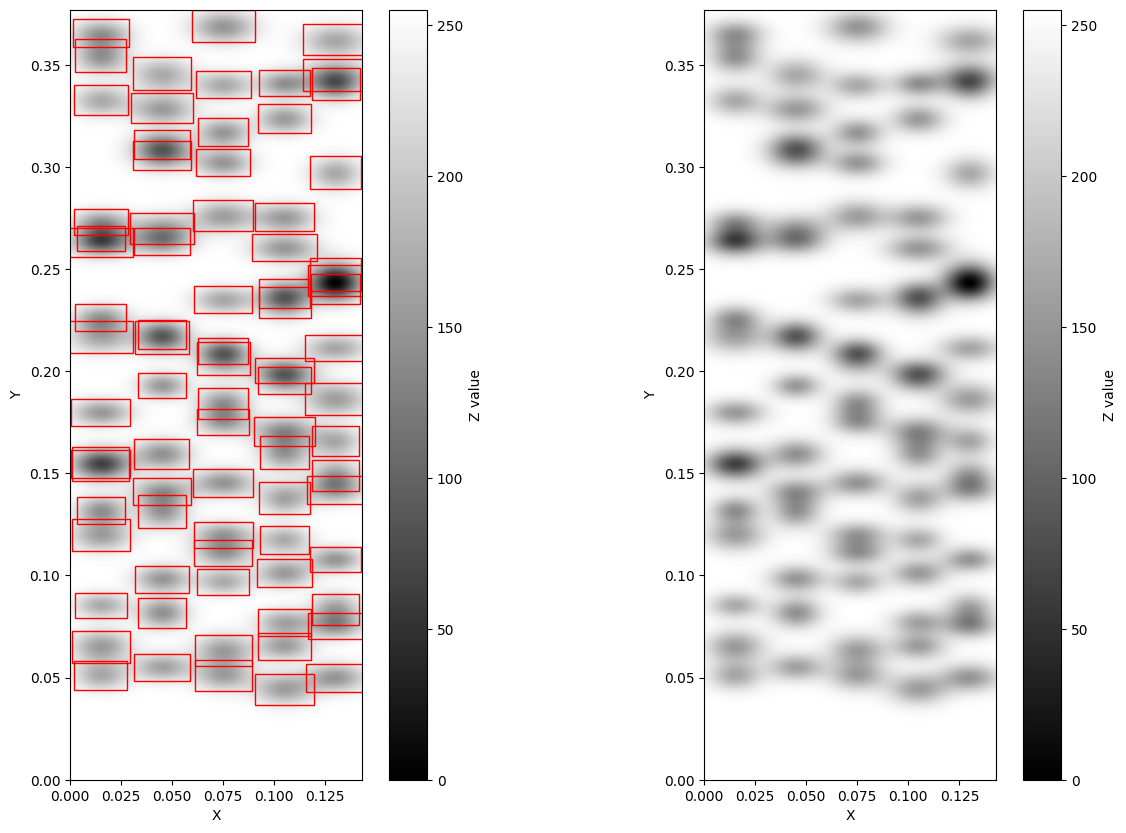

In [ ]:
# Plot ground truth labels
n_image = 3
labels_type = "Labelsv0_detect"
task = "detect"
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[0],
                   task = task)

plot_grayscale(x, y, z, ax = axs[1])

In [ ]:
# Labels problem in Yolo
lines = load_label(label_path).split("\n")
# Step 2: Split each line into columns using spaces as the separator
labels = [line.split() for line in lines]
df_labels = pd.DataFrame(labels)

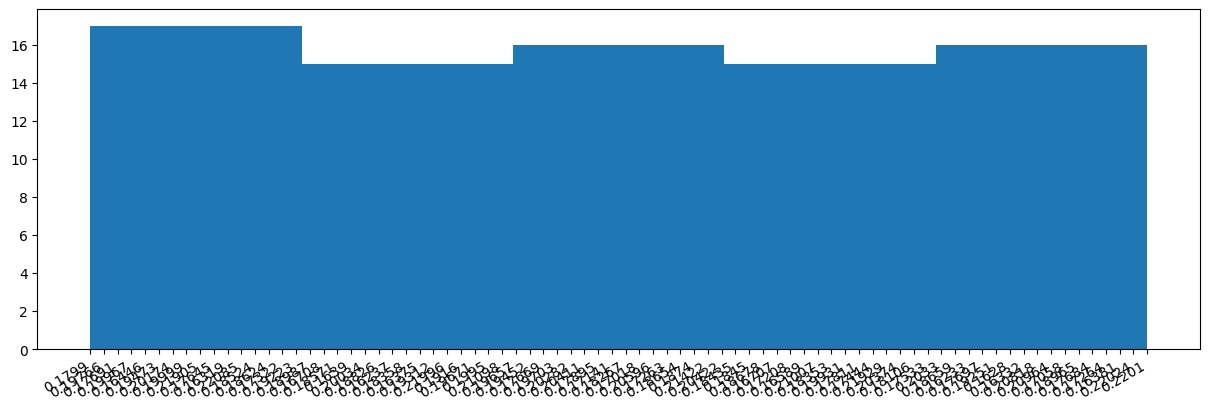

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.hist(df_labels[[3]], bins = 5)
fig.autofmt_xdate()

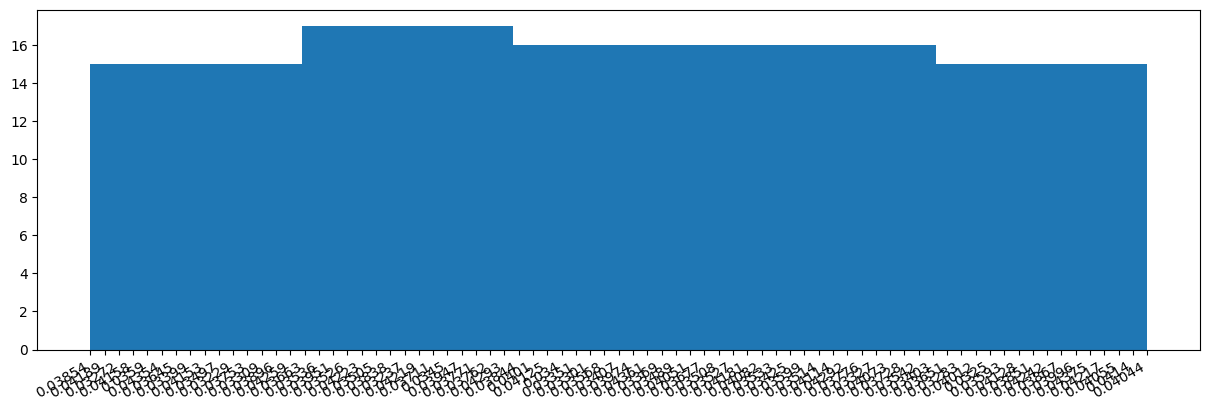

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.hist(df_labels[[4]], bins = 5)
fig.autofmt_xdate()

### Image distribution

In [ ]:
"""
Image distribution for YoloV0
  - Images from 600 a 799
  - Labels without  gaussians with center out of the image
"""
labels_type = "Labelsv0_detect"
yolo_type = "YOLOv0_E4_detect"
yolo_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{yolo_type}/datasets/"
images_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"
labels_folder= f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/"
range_images = list(range(600, 800))
proportions = {'train': 0.7, 'val': 0.2, 'test': 0.1}

ppl_distribute_images_yolo(images_folder,
                           labels_folder,
                           yolo_folder,
                           range_images,
                           proportions)

In [ ]:
# Config Yolo model to train
yolo_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{yolo_type}/"
yaml_content = (f'''
                train: {os.path.join(yolo_folder, "datasets/train/images")}
                val: {os.path.join(yolo_folder, "datasets/val/images")}
                test: {os.path.join(yolo_folder, "datasets/test/images")}
                names: ['gaussian']
                ''')

with open(os.path.join(yolo_folder,'data.yaml'), 'w') as f:
    f.write(yaml_content)

### Training model - YOLOv0

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [ ]:
# Load nano model
model = YOLO("yolov8s.pt") # "yolov8s-seg.pt"

100%|██████████| 21.5M/21.5M [00:00<00:00, 158MB/s]


In [ ]:
# Train
model_name = "YOLOv0_E4_detect"
yolo_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}"
results = model.train(
        device = 0, # "cpu"
        batch = -1,
        patience = 100,
        task = "detect",
        data = os.path.join(yolo_folder,'data.yaml'),
        epochs = 100,
    )

New https://pypi.org/project/ultralytics/8.0.158 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/data.yaml, epochs=100, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None,

In [ ]:
# Copy results
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
shutil.copytree(Path("/content/runs/"), Path(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{timestamp}"))

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/runs/2023-08-21_14-37-58')

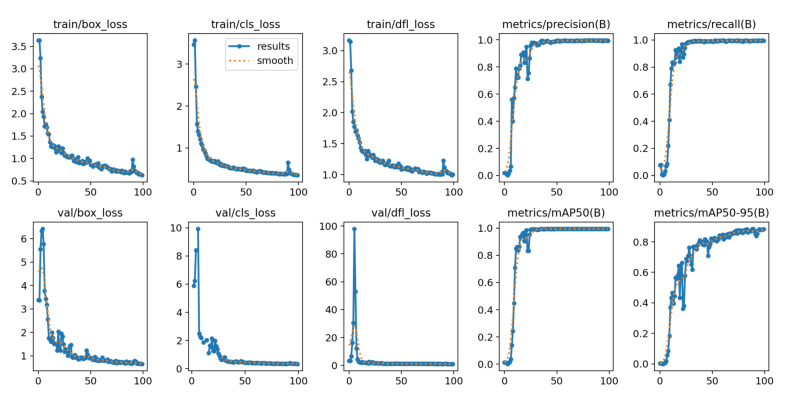

In [ ]:
task = "detect"
plotting.plot_results(f'/content/runs/{task}/train/results.csv')
image = Image.open(f'/content/runs/{task}/train/results.png')
fig = plt.figure(figsize = (10, 8))
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

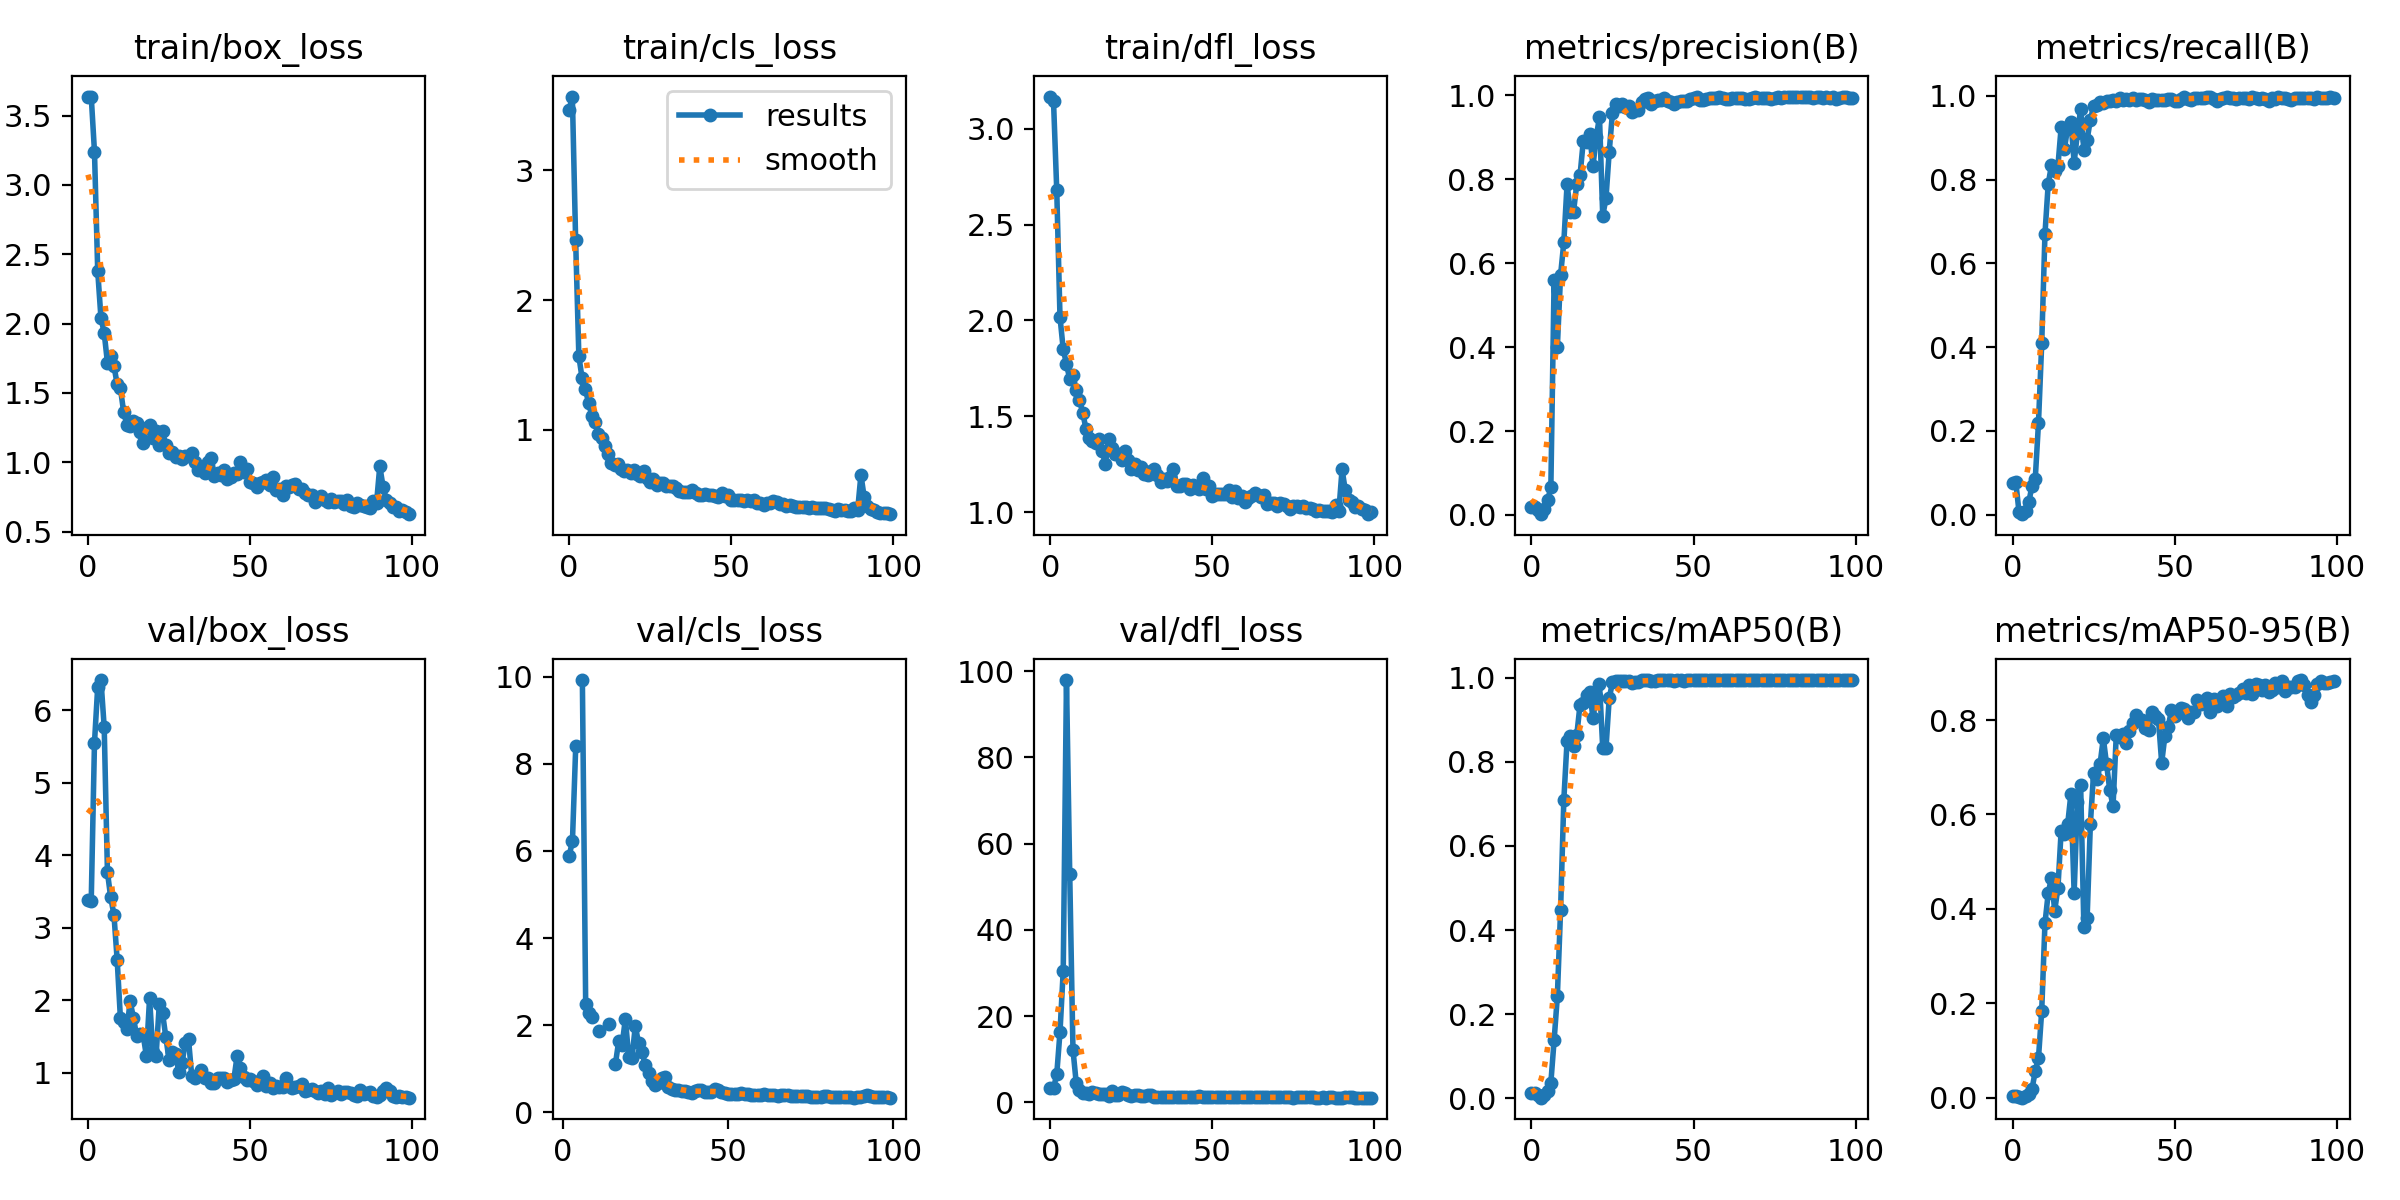

In [ ]:
image

### Predict with custom model - YOLOv0

In [24]:
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models")

['YOLOv0_detect',
 'YOLOv0_E2_detect',
 'YOLOv0_E3_detect',
 'YOLOv0_E12_detect',
 'YOLOv0_E4_detect',
 'Archive',
 'YOLOv0_E1_detect',
 'YOLOv0_T80kenji_detect']

In [25]:
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/datasets/test/images/")

['gaussian_738.png',
 'gaussian_777.png',
 'gaussian_650.png',
 'gaussian_772.png',
 'gaussian_703.png',
 'gaussian_704.png',
 'gaussian_726.png',
 'gaussian_710.png',
 'gaussian_601.png',
 'gaussian_622.png',
 'gaussian_664.png',
 'gaussian_694.png',
 'gaussian_690.png',
 'gaussian_700.png',
 'gaussian_605.png',
 'gaussian_719.png',
 'gaussian_614.png',
 'gaussian_603.png',
 'gaussian_766.png',
 'gaussian_714.png']

In [26]:
n_image = 601
image_ranges = [(0, 0.143), (0, 0.377)]
image_size = [143, 377]

labels_type = "Labelsv0_detect"
task = "detect"
model_name = "YOLOv0_E4_detect"
date_train = "2023-08-21_14-37-58"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

In [27]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes = results[0].boxes.xyxy

# Centers
means_yolo = [(float(x),
          float(y)) for
          x,y in zip(results[0].boxes.xywhn[:, 0] * image_size[0],
                     results[0].boxes.xywhn[:, 1] * image_size[1])]


0: 640x256 77 gaussians, 635.7ms
Speed: 17.2ms preprocess, 635.7ms inference, 36.5ms postprocess per image at shape (1, 3, 640, 256)


Number of indentifiable Gaussians (center in the image): 76


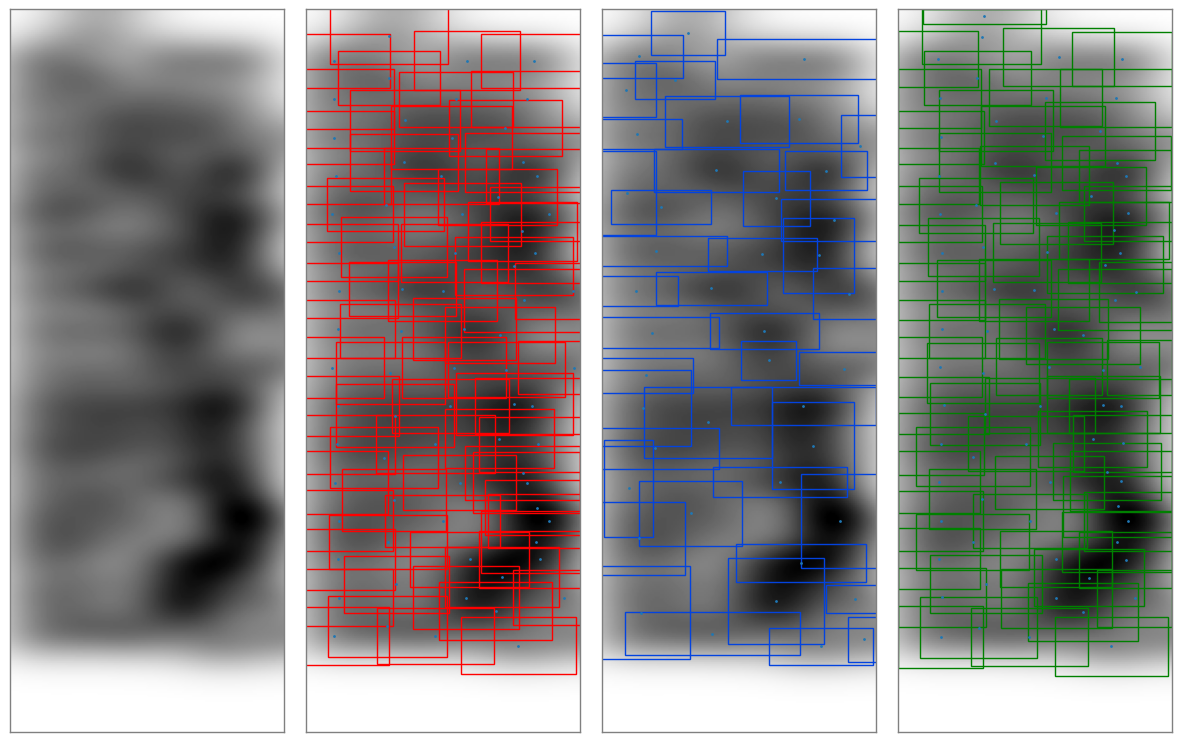

In [28]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize = (15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes_gmm(means = means,
               covariances = covariances,
               ax = axs[2],
               beta = 3,
               edge_color = '#0343DF')
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:,0] * 1000, means[:, 1] * 1000, s = 1)
# axs[3].axis('off')
axs[2].set_xlim(0, 143)
axs[2].set_ylim(0, 377)


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes,
           axs[3],
           edge_color = 'g')
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means_yolo )[:,0], np.array(means_yolo)[:, 1], s = 1)
# axs[2].axis('off')
axs[3].set_xlim(0, 143)
axs[3].set_ylim(0, 377)

#axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = task,
                   colorbar = False,
                   plot_centers = True)
# axs[1].axis('off')
axs[1].set_xlim(0, 0.143)
axs[1].set_ylim(0, 0.377)
#axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, 0.143)
axs[0].set_ylim(0, 0.377)


for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

  ax.set_xticks([])
  ax.set_yticks([])
  # Change the color of the axis spines (borders)
  for spine in ax.spines.values():
      spine.set_edgecolor('gray')
      spine.set_linewidth(1)

plt.subplots_adjust(wspace= 0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[738, 777, 650, 772, 703, 704, 726, 710, 601, 622, 664, 694, 690, 700, 605, 719, 614, 603, 766, 714]


In [ ]:
# Load our custom model
model_name = "YOLOv0_E4_detect"
task = "detect"
date_train = "2023-08-21_14-37-58"

model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Image root path
image_path = "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO' : [],
           'Number identifiable - YOLO' : [],
           'Percentage - YOLO' : [],
           'RMSE_cx - YOLO' : [],
           'RMSE_cy - YOLO' : [],
           'RMSE_c - YOLO' : [],
           'RMSE_sigmax - YOLO' : [],
           'RMSE_sigmay - YOLO' : [],
           'RMSE_sigma - YOLO' : [],
           'MaxE_sigmax - YOLO': [],
           'MaxE_sigmay - YOLO': [],
           'MaxE_sigma - YOLO': [],
           'RMSE_amplitude - YOLO': [],
           'RMSEPixel - YOLO': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO",
                                       image_path = image_path,
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 78 gaussians, 218.9ms
Speed: 1.4ms preprocess, 218.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027097           0]
  [          0    0.013563]]]
covariances true [[[   0.025709           0]
  [          0    0.013859]]]



0: 640x256 81 gaussians, 193.2ms
Speed: 1.7ms preprocess, 193.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027385           0]
  [          0    0.014418]]]
covariances true [[[   0.026342           0]
  [          0    0.014722]]]



0: 640x256 79 gaussians, 176.0ms
Speed: 1.7ms preprocess, 176.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028106           0]
  [          0    0.014089]]]
covariances true [[[   0.028893           0]
  [          0    0.013613]]]



0: 640x256 77 gaussians, 178.9ms
Speed: 1.3ms preprocess, 178.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027477           0]
  [          0    0.014942]]]
covariances true [[[   0.026338           0]
  [          0    0.014706]]]



0: 640x256 79 gaussians, 251.9ms
Speed: 2.2ms preprocess, 251.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019863           0]
  [          0    0.013598]]]
covariances true [[[   0.024871           0]
  [          0    0.013338]]]



0: 640x256 79 gaussians, 276.1ms
Speed: 1.3ms preprocess, 276.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.022204           0]
  [          0    0.014646]]]
covariances true [[[   0.026967           0]
  [          0    0.014712]]]



0: 640x256 79 gaussians, 246.4ms
Speed: 1.3ms preprocess, 246.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029166           0]
  [          0    0.014775]]]
covariances true [[[   0.028546           0]
  [          0    0.015468]]]



0: 640x256 80 gaussians, 242.3ms
Speed: 1.4ms preprocess, 242.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021174           0]
  [          0    0.013209]]]
covariances true [[[   0.026111           0]
  [          0    0.013102]]]



0: 640x256 77 gaussians, 177.1ms
Speed: 1.7ms preprocess, 177.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021093           0]
  [          0    0.013115]]]
covariances true [[[   0.029306           0]
  [          0    0.013158]]]



0: 640x256 80 gaussians, 179.1ms
Speed: 2.0ms preprocess, 179.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021547           0]
  [          0     0.01341]]]
covariances true [[[   0.029414           0]
  [          0    0.013297]]]



0: 640x256 78 gaussians, 183.1ms
Speed: 1.5ms preprocess, 183.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021494           0]
  [          0    0.013726]]]
covariances true [[[   0.026696           0]
  [          0    0.013155]]]



0: 640x256 78 gaussians, 179.2ms
Speed: 1.4ms preprocess, 179.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020683           0]
  [          0    0.014477]]]
covariances true [[[   0.027244           0]
  [          0    0.014346]]]



0: 640x256 75 gaussians, 173.4ms
Speed: 1.1ms preprocess, 173.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020754           0]
  [          0    0.014394]]]
covariances true [[[   0.026944           0]
  [          0    0.014774]]]



0: 640x256 81 gaussians, 185.6ms
Speed: 1.6ms preprocess, 185.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020411           0]
  [          0    0.013768]]]
covariances true [[[   0.025956           0]
  [          0    0.014246]]]



0: 640x256 79 gaussians, 187.4ms
Speed: 1.4ms preprocess, 187.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020054           0]
  [          0    0.014909]]]
covariances true [[[   0.026697           0]
  [          0    0.014919]]]



0: 640x256 81 gaussians, 177.5ms
Speed: 1.4ms preprocess, 177.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020998           0]
  [          0    0.015582]]]
covariances true [[[   0.025486           0]
  [          0    0.015243]]]



0: 640x256 78 gaussians, 178.1ms
Speed: 2.2ms preprocess, 178.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.026662           0]
  [          0    0.014155]]]
covariances true [[[   0.025318           0]
  [          0     0.01372]]]



0: 640x256 80 gaussians, 179.6ms
Speed: 1.9ms preprocess, 179.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021479           0]
  [          0    0.015493]]]
covariances true [[[   0.025979           0]
  [          0    0.015276]]]



0: 640x256 79 gaussians, 178.3ms
Speed: 1.7ms preprocess, 178.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028559           0]
  [          0    0.014599]]]
covariances true [[[   0.027789           0]
  [          0     0.01536]]]



0: 640x256 79 gaussians, 173.9ms
Speed: 3.1ms preprocess, 173.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.022105           0]
  [          0    0.014874]]]
covariances true [[[   0.029515           0]
  [          0    0.013938]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean        std         max
Image                           688.60      56.81      777.00
Number identified - YOLO         78.85       1.50       81.00
Number identifiable - YOLO       75.30       1.42       77.00
Percentage - YOLO               104.74       2.27      108.11
RMSE_cx - YOLO                   11.71       0.59       13.22
RMSE_cy - YOLO                    0.35       0.22        1.28
RMSE_c - YOLO                    11.71       0.60       13.28
RMSE_sigmax - YOLO               12.40       0.79       13.61
RMSE_sigmay - YOLO                3.85       0.42        5.27
RMSE_sigma - YOLO                12.99       0.71       14.14
MaxE_sigmax - YOLO               53.98       5.08       62.56
MaxE_sigmay - YOLO               74.32       2.69       79.40
MaxE_sigma - YOLO                91.96       3.67       99.20
RMSE_amplitude - YOLO           101.06       3.57      108.37
RMSEPixel - YOLO            5617755.00  240974.22  6008307.31

In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

Image  Number identified - YOLO  Number identifiable - YOLO  \
8     601                        77                          76   
17    603                        80                          77   
14    605                        79                          76   
16    614                        78                          77   
9     622                        80                          76   
2     650                        79                          74   
10    664                        78                          73   
12    690                        75                          75   
11    694                        78                          74   
13    700                        81                          77   
4     703                        79                          74   
5     704                        79                          74   
7     710                        80                          74   
19    714                        79                          76   
15    719                        81                          76   
6     726                        79                          76   
0     738                        78                          77   
18    766                        79                          74   
3     772                        77                          73   
1     777                        81                          77   

    Percentage - YOLO  RMSE_cx - YOLO  RMSE_cy - YOLO  RMSE_c - YOLO  \
8              101.32           10.67            0.28          10.68   
17             103.90           11.30            0.27          11.30   
14             103.95           11.35            0.41          11.36   
16             101.30           11.36            0.34          11.37   
9              105.26           12.33            0.28          12.33   
2              106.76           11.72            0.27          11.72   
10             106.85           11.80            0.25          11.81   
12             100.00           12.23            0.30          12.24   
11             105.41           12.49            0.25          12.50   
13             105.19           11.50            0.31          11.50   
4              106.76           11.67            0.33          11.68   
5              106.76           12.30            0.34          12.30   
7              108.11           11.25            0.31          11.26   
19             103.95           13.22            1.28          13.28   
15             106.58           11.45            0.33          11.45   
6              103.95           11.48            0.28          11.48   
0              101.30           12.01            0.32          12.01   
18             106.76           11.74            0.27          11.74   
3              105.48           10.87            0.27          10.88   
1              105.19           11.40            0.28          11.41   

    RMSE_sigmax - YOLO  RMSE_sigmay - YOLO  RMSE_sigma - YOLO  \
8                10.41                4.03              11.16   
17               12.63                3.19              13.03   
14               11.64                3.90              12.28   
16               11.60                3.64              12.16   
9                13.45                3.44              13.88   
2                13.61                3.84              14.14   
10               12.82                3.71              13.34   
12               11.69                4.01              12.36   
11               12.53                3.84              13.10   
13               12.54                4.22              13.23   
4                12.58                3.58              13.08   
5                13.39                4.04              13.98   
7                12.81                4.01              13.42   
19               11.36                5.27              12.53   
15               12.54                3.73              13.08   
6                12.28                3.57 

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E4YOLO")

## [ESTIMATION] Pipeline ppl_SCIKIT_PX
- Center estimation using SCIKIT / Yolo
- FWHM estimation using the density distribution

In [ ]:
# Load data
n_image = 609
image_ranges = [(0, 0.143), (0, 0.377)]
image_size = [143, 377]

# Generate GRID
x, y = generate_grid((0, image_ranges[0][-1]),
                     (0, image_ranges[1][-1]),
                     image_size[0],
                     image_size[1])

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Predict Gaussian centers
# nonzero_pairs, center_coordinates = estimate_gaussians_centers(image,
#                                                      peak_method = 'laplace')

In [ ]:
# Predict Yolo
labels_type = "Labelsv0_detect"
task = "detect"
model_name = "YOLOv0_E4_detect"
date_train = "2023-08-21_14-37-58"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

(means,
 covariances,
 amplitudes_yolo) = ppl_yolo_predict_gaussians(mat,
                                               n_image,
                                               model,
                                               image_path,
                                               image_ranges = image_ranges,
                                               image_size = image_size)


0: 640x256 81 gaussians, 197.5ms
Speed: 1.1ms preprocess, 197.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means,
new_covariances,
amplitudes_px,
new_means,
new_covariances_up,
new_covariances_down) = ppl_yolo_px_predict_gaussians(mat,
                                                      n_image,
                                                      model,
                                                      image_path,
                                                      px_step_size = 3)


0: 640x256 81 gaussians, 282.9ms
Speed: 3.4ms preprocess, 282.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means_infer,
new_covariances_infer,
amplitudes_px_infer,
new_means_infer,
new_covariances_up_infer,
new_covariances_down_infer) = ppl_yolo_px_predict_gaussians(mat,
                                                            n_image,
                                                            model,
                                                            image_path,
                                                            px_step_size = 3,
                                                            infer_overlapping = True)


0: 640x256 81 gaussians, 297.4ms
Speed: 1.5ms preprocess, 297.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


### Study - covariances overlapping

In [ ]:
# Flag potential hard overlappings (negative relation of amplitudes)
# Hard overlappings = the peak of one Gaussians is really close to another one
overlap_ups_x = [i[0][0] < 0 for i in new_covariances_up] # Right
overlap_downs_x = [i[0][0] < 0 for i in new_covariances_down] # Left
overlap_ups_y = [i[1][1] < 0 for i in new_covariances_up]
overlap_downs_y = [i[1][1] < 0 for i in new_covariances_down]

# Print probable overlappings
print(f'overlap up x : {np.sum(np.array(overlap_ups_x))}')
print(f'overlap down x : {np.sum(np.array(overlap_downs_x))}')
print(f'overlap up y : {np.sum(np.array(overlap_ups_y))}')
print(f'overlap down y : {np.sum(np.array(overlap_downs_y))}')

overlap up x : 0
overlap down x : 1
overlap up y : 8
overlap down y : 13


In [ ]:
# Difference of covariance up and down
diffs_cov_x = [i[0][0] - j[0][0] for (i, j) in zip(new_covariances_up,
                                                   new_covariances_down)]
diffs_cov_y = [i[1][1] - j[1][1] for (i, j) in zip(new_covariances_up,
                                                   new_covariances_down)]

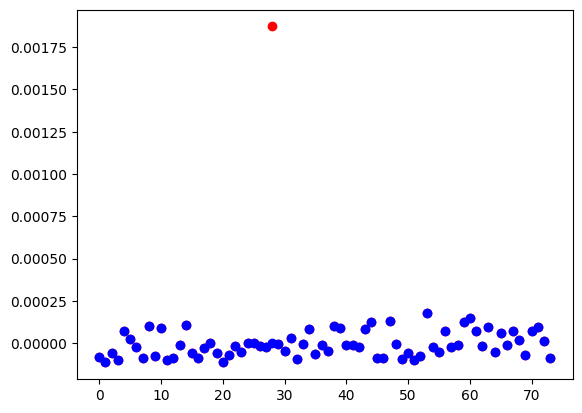

In [ ]:
# Check outlier
diffs_x_onmargin = remove_outliers_using_iqr(diffs_cov_x)
plt.scatter(range(len(diffs_cov_x)), diffs_cov_x, color = 'red')
plt.scatter(range(len(diffs_cov_x)),np.multiply(np.array(diffs_cov_x), np.array(diffs_x_onmargin).astype(int)), color = 'blue')

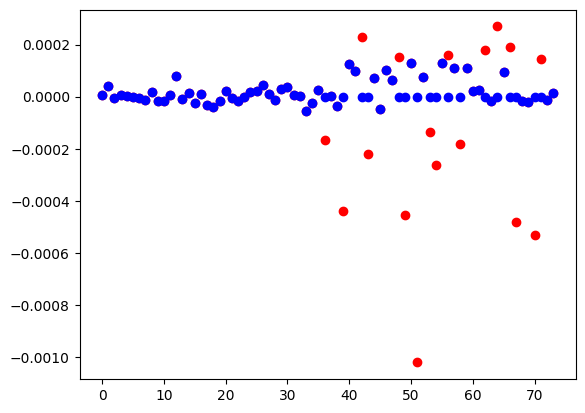

In [ ]:
a# Check outlier
diffs_y_onmargin = remove_outliers_using_iqr(diffs_cov_y)
plt.scatter(range(len(diffs_cov_y)), diffs_cov_y, color = 'red')
plt.scatter(range(len(diffs_cov_y)),np.multiply(np.array(diffs_cov_y),
                                                np.array(diffs_y_onmargin).astype(int)), color = 'blue')

In [ ]:
# OK - integrar no pipeline
new_covariances_modified = replace_covariances_outlier(new_covariances.copy(),
                                                       new_covariances_up,
                                                       new_covariances_down)

### Evaluate - Plot truth, YOLO and PX

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in converted_new_means],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(new_covariances[:, 0, 0]),
                                       np.sqrt(new_covariances[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b', # CENTER COLOR
                                  annotate_gaussians = True,
                                  text_color = 'blue')

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g', # BOX COLOR
                                        center_color = 'g', # CENTER COLOR
                                        annotate_gaussians = True)

In [ ]:
# Plot box and center - YOLO
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
task = "detect"
model_name = "YOLOv0_E4_detect"
date_train = "2023-08-21_14-37-58"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = image_ranges,
                                          image_size = image_size)

# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in
                  zip(np.sqrt(covariances[:, 0, 0]),
                      np.sqrt(covariances[:, 1, 1]))],
                ax = ax,
                box_edge_color = 'b', # BOX COLOR
                center_color = 'red', # CENTER COLOR
                annotate_gaussians = False)


0: 640x256 81 gaussians, 200.5ms
Speed: 1.7ms preprocess, 200.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
adjust_text(all_texts)

62

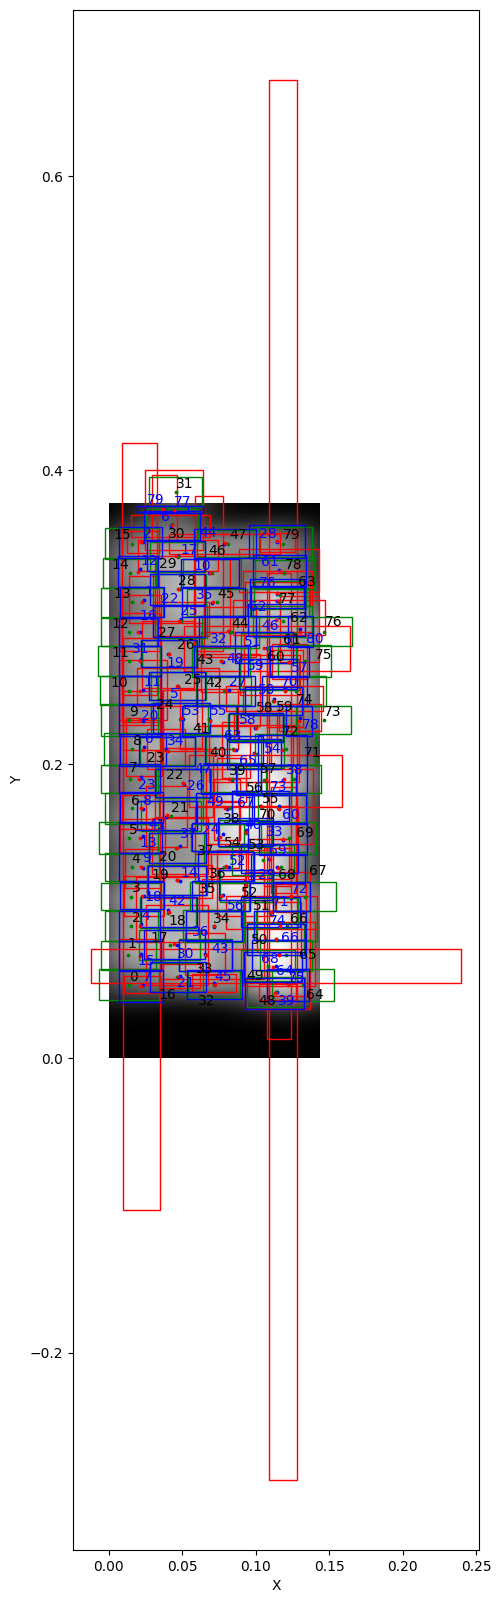

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
# Load our custom model
model_name = "YOLOv0_E4_detect"
task = "detect"
date_train = "2023-08-21_14-37-58"

model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Image root path
image_path = "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO_px' : [],
           'Number identifiable - YOLO_px' : [],
           'Percentage - YOLO_px' : [],
           'RMSE_cx - YOLO_px' : [],
           'RMSE_cy - YOLO_px' : [],
           'RMSE_c - YOLO_px' : [],
           'RMSE_sigmax - YOLO_px' : [],
           'RMSE_sigmay - YOLO_px' : [],
           'RMSE_sigma - YOLO_px' : [],
           'MaxE_sigmax - YOLO_px': [],
           'MaxE_sigmay - YOLO_px': [],
           'MaxE_sigma - YOLO_px': [],
           'RMSE_amplitude - YOLO_px': [],
           'RMSEPixel - YOLO_px': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO_px",
                                       image_path = image_path,
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 78 gaussians, 216.8ms
Speed: 1.6ms preprocess, 216.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.11667           0]
  [          0    0.021301]]]
covariances true [[[   0.025709           0]
  [          0    0.013859]]]



0: 640x256 81 gaussians, 190.1ms
Speed: 2.9ms preprocess, 190.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015966           0]
  [          0    0.015043]]]
covariances true [[[   0.026342           0]
  [          0    0.014722]]]



0: 640x256 79 gaussians, 248.3ms
Speed: 1.5ms preprocess, 248.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017858           0]
  [          0    0.026967]]]
covariances true [[[   0.028893           0]
  [          0    0.013613]]]



0: 640x256 77 gaussians, 248.7ms
Speed: 1.3ms preprocess, 248.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.012408           0]
  [          0   0.0097907]]]
covariances true [[[   0.026338           0]
  [          0    0.014706]]]



0: 640x256 79 gaussians, 255.2ms
Speed: 1.6ms preprocess, 255.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01852           0]
  [          0    0.055742]]]
covariances true [[[   0.024871           0]
  [          0    0.013338]]]



0: 640x256 79 gaussians, 513.4ms
Speed: 7.8ms preprocess, 513.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015199           0]
  [          0   0.0095993]]]
covariances true [[[   0.026967           0]
  [          0    0.014712]]]



0: 640x256 79 gaussians, 264.6ms
Speed: 1.2ms preprocess, 264.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027856           0]
  [          0    0.016731]]]
covariances true [[[   0.028546           0]
  [          0    0.015468]]]



0: 640x256 80 gaussians, 312.2ms
Speed: 1.7ms preprocess, 312.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017788           0]
  [          0    0.022437]]]
covariances true [[[   0.026111           0]
  [          0    0.013102]]]



0: 640x256 77 gaussians, 243.6ms
Speed: 1.2ms preprocess, 243.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019243           0]
  [          0    0.040063]]]
covariances true [[[   0.029306           0]
  [          0    0.013158]]]



0: 640x256 80 gaussians, 253.5ms
Speed: 1.2ms preprocess, 253.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01608           0]
  [          0    0.037664]]]
covariances true [[[   0.029414           0]
  [          0    0.013297]]]



0: 640x256 78 gaussians, 240.1ms
Speed: 1.3ms preprocess, 240.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018449           0]
  [          0    0.020171]]]
covariances true [[[   0.026696           0]
  [          0    0.013155]]]



0: 640x256 78 gaussians, 246.1ms
Speed: 1.2ms preprocess, 246.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.021656           0]
  [          0    0.032287]]]
covariances true [[[   0.027244           0]
  [          0    0.014346]]]



0: 640x256 75 gaussians, 245.0ms
Speed: 1.2ms preprocess, 245.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015775           0]
  [          0    0.020624]]]
covariances true [[[   0.026944           0]
  [          0    0.014774]]]



0: 640x256 81 gaussians, 196.5ms
Speed: 1.3ms preprocess, 196.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021978           0]
  [          0    0.051392]]]
covariances true [[[   0.025956           0]
  [          0    0.014246]]]



0: 640x256 79 gaussians, 187.4ms
Speed: 1.2ms preprocess, 187.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.024401           0]
  [          0     0.15384]]]
covariances true [[[   0.026697           0]
  [          0    0.014919]]]



0: 640x256 81 gaussians, 187.1ms
Speed: 2.3ms preprocess, 187.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015331           0]
  [          0    0.010483]]]
covariances true [[[   0.025486           0]
  [          0    0.015243]]]



0: 640x256 78 gaussians, 180.2ms
Speed: 1.4ms preprocess, 180.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012427           0]
  [          0    0.010436]]]
covariances true [[[   0.025318           0]
  [          0     0.01372]]]



0: 640x256 80 gaussians, 189.9ms
Speed: 1.6ms preprocess, 189.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018056           0]
  [          0   0.0081103]]]
covariances true [[[   0.025979           0]
  [          0    0.015276]]]



0: 640x256 79 gaussians, 194.5ms
Speed: 1.1ms preprocess, 194.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020495           0]
  [          0    0.031231]]]
covariances true [[[   0.027789           0]
  [          0     0.01536]]]



0: 640x256 79 gaussians, 187.8ms
Speed: 1.3ms preprocess, 187.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01821           0]
  [          0   0.0083593]]]
covariances true [[[   0.029515           0]
  [          0    0.013938]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean         std          max
Image                               688.60       56.81       777.00
Number identified - YOLO_px          78.85        1.50        81.00
Number identifiable - YOLO_px        75.30        1.42        77.00
Percentage - YOLO_px                104.74        2.27       108.11
RMSE_cx - YOLO_px                    13.35        0.66        15.02
RMSE_cy - YOLO_px                     0.70        0.24         1.71
RMSE_c - YOLO_px                     13.37        0.67        15.11
RMSE_sigmax - YOLO_px                46.03        8.33        72.97
RMSE_sigmay - YOLO_px               106.55       29.76       204.02
RMSE_sigma - YOLO_px                116.63       28.61       209.17
MaxE_sigmax - YOLO_px               485.51      365.90      1734.32
MaxE_sigmay - YOLO_px              1524.43     1763.08      8393.86
MaxE_sigma - YOLO_px               1663.18     1739.23      8410.50
RMSE_amplitude - YOLO_px            104.11        3.55       111.11
RMSEPixel - YOLO_px            15855944.17  2094759.89  20876384.95

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E4YOLOPX")

## Evaluate - Plot Truth, YOLO and PX infer

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in converted_new_means_infer],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(new_covariances_infer[:, 0, 0]),
                                       np.sqrt(new_covariances_infer[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b', # CENTER COLOR
                                  annotate_gaussians = True,
                                  text_color = 'blue')

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g', # BOX COLOR
                                        center_color = 'g', # CENTER COLOR
                                        annotate_gaussians = True)

In [ ]:
# Plot box and center -  YOLO
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in
                  zip(np.sqrt(covariances[:, 0, 0]),
                      np.sqrt(covariances[:, 1, 1]))],
                ax = ax,
                box_edge_color = 'b', # BOX COLOR
                center_color = 'red', # CENTER COLOR
                annotate_gaussians = False)

In [ ]:
adjust_text(all_texts)

6

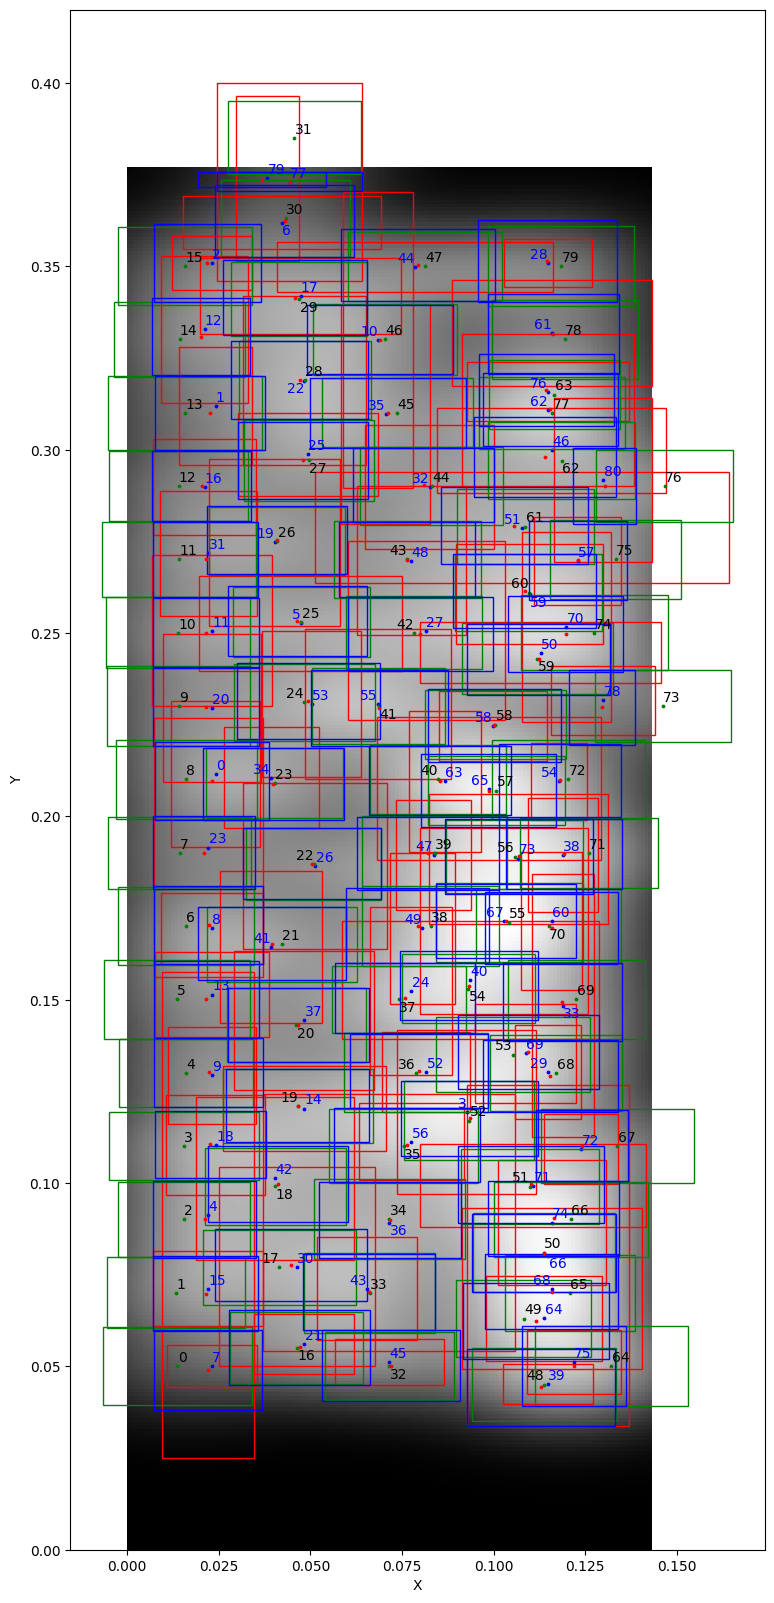

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX Infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
# Load our custom model
model_name = "YOLOv0_E4_detect"
task = "detect"
date_train = "2023-08-21_14-37-58"

model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Image root path
image_path = "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO_px_infer' : [],
           'Number identifiable - YOLO_px_infer' : [],
           'Percentage - YOLO_px_infer' : [],
           'RMSE_cx - YOLO_px_infer' : [],
           'RMSE_cy - YOLO_px_infer' : [],
           'RMSE_c - YOLO_px_infer' : [],
           'RMSE_sigmax - YOLO_px_infer' : [],
           'RMSE_sigmay - YOLO_px_infer' : [],
           'RMSE_sigma - YOLO_px_infer' : [],
           'MaxE_sigmax - YOLO_px_infer': [],
           'MaxE_sigmay - YOLO_px_infer': [],
           'MaxE_sigma - YOLO_px_infer': [],
           'RMSE_amplitude - YOLO_px_infer': [],
           'RMSEPixel - YOLO_px_infer': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO_px_infer",
                                       image_path = image_path,
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 78 gaussians, 204.8ms
Speed: 2.2ms preprocess, 204.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.11667           0]
  [          0    0.021301]]]
covariances true [[[   0.025709           0]
  [          0    0.013859]]]



0: 640x256 81 gaussians, 179.5ms
Speed: 1.5ms preprocess, 179.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015966           0]
  [          0    0.015043]]]
covariances true [[[   0.026342           0]
  [          0    0.014722]]]



0: 640x256 79 gaussians, 181.5ms
Speed: 1.3ms preprocess, 181.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017858           0]
  [          0    0.026967]]]
covariances true [[[   0.028893           0]
  [          0    0.013613]]]



0: 640x256 77 gaussians, 179.7ms
Speed: 2.0ms preprocess, 179.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.012408           0]
  [          0   0.0097907]]]
covariances true [[[   0.026338           0]
  [          0    0.014706]]]



0: 640x256 79 gaussians, 181.7ms
Speed: 1.4ms preprocess, 181.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01852           0]
  [          0    0.055742]]]
covariances true [[[   0.024871           0]
  [          0    0.013338]]]



0: 640x256 79 gaussians, 191.0ms
Speed: 1.6ms preprocess, 191.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015199           0]
  [          0   0.0095993]]]
covariances true [[[   0.026967           0]
  [          0    0.014712]]]



0: 640x256 79 gaussians, 191.2ms
Speed: 1.2ms preprocess, 191.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027856           0]
  [          0    0.016731]]]
covariances true [[[   0.028546           0]
  [          0    0.015468]]]



0: 640x256 80 gaussians, 180.9ms
Speed: 2.1ms preprocess, 180.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017788           0]
  [          0    0.022437]]]
covariances true [[[   0.026111           0]
  [          0    0.013102]]]



0: 640x256 77 gaussians, 254.1ms
Speed: 2.6ms preprocess, 254.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019243           0]
  [          0    0.040063]]]
covariances true [[[   0.029306           0]
  [          0    0.013158]]]



0: 640x256 80 gaussians, 282.8ms
Speed: 1.7ms preprocess, 282.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01608           0]
  [          0    0.037664]]]
covariances true [[[   0.029414           0]
  [          0    0.013297]]]



0: 640x256 78 gaussians, 248.6ms
Speed: 1.9ms preprocess, 248.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018449           0]
  [          0    0.020171]]]
covariances true [[[   0.026696           0]
  [          0    0.013155]]]



0: 640x256 78 gaussians, 266.2ms
Speed: 1.4ms preprocess, 266.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.021656           0]
  [          0    0.032287]]]
covariances true [[[   0.027244           0]
  [          0    0.014346]]]



0: 640x256 75 gaussians, 259.9ms
Speed: 3.9ms preprocess, 259.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015775           0]
  [          0    0.020624]]]
covariances true [[[   0.026944           0]
  [          0    0.014774]]]



0: 640x256 81 gaussians, 291.9ms
Speed: 1.1ms preprocess, 291.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021978           0]
  [          0    0.051392]]]
covariances true [[[   0.025956           0]
  [          0    0.014246]]]



0: 640x256 79 gaussians, 277.2ms
Speed: 1.3ms preprocess, 277.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.024401           0]
  [          0     0.15384]]]
covariances true [[[   0.026697           0]
  [          0    0.014919]]]



0: 640x256 81 gaussians, 876.0ms
Speed: 1.4ms preprocess, 876.0ms inference, 13.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015331           0]
  [          0    0.010483]]]
covariances true [[[   0.025486           0]
  [          0    0.015243]]]



0: 640x256 78 gaussians, 300.4ms
Speed: 1.4ms preprocess, 300.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012427           0]
  [          0    0.010436]]]
covariances true [[[   0.025318           0]
  [          0     0.01372]]]



0: 640x256 80 gaussians, 273.2ms
Speed: 1.4ms preprocess, 273.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018056           0]
  [          0   0.0081103]]]
covariances true [[[   0.025979           0]
  [          0    0.015276]]]



0: 640x256 79 gaussians, 305.6ms
Speed: 1.4ms preprocess, 305.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020495           0]
  [          0    0.031231]]]
covariances true [[[   0.027789           0]
  [          0     0.01536]]]



0: 640x256 79 gaussians, 262.4ms
Speed: 1.5ms preprocess, 262.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01821           0]
  [          0   0.0083593]]]
covariances true [[[   0.029515           0]
  [          0    0.013938]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean         std          max
Image                                     688.60       56.81       777.00
Number identified - YOLO_px_infer          78.85        1.50        81.00
Number identifiable - YOLO_px_infer        75.30        1.42        77.00
Percentage - YOLO_px_infer                104.74        2.27       108.11
RMSE_cx - YOLO_px_infer                    13.35        0.66        15.02
RMSE_cy - YOLO_px_infer                     0.70        0.24         1.71
RMSE_c - YOLO_px_infer                     13.37        0.67        15.11
RMSE_sigmax - YOLO_px_infer                39.05        4.48        53.27
RMSE_sigmay - YOLO_px_infer                80.30       12.75       106.17
RMSE_sigma - YOLO_px_infer                 89.49       12.07       118.79
MaxE_sigmax - YOLO_px_infer               302.97      238.70      1261.15
MaxE_sigmay - YOLO_px_infer               595.37      482.44      2296.18
MaxE_sigma - YOLO_px_infer                683.02      518.08      2619.72
RMSE_amplitude - YOLO_px_infer            104.11        3.55       111.11
RMSEPixel - YOLO_px_infer            13774426.56  1552717.20  18144430.97

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E4YOLOPXINFER")

## [ESTIMATION] Pipeline ensembled (PX and YOLO)

In [ ]:
# Load data
n_image = 609

# Image - z intensities
image = [x,
         y,
         mat['F_data'][:,:, n_image]]

image_ranges = [(0, 0.143),
                (0, 0.377)]
image_size = [143, 377]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

#### ERROR MSEP evaluation - YOLO + Refinning -
- Compare values by reconstruction with the estimated parameters (per Gaussian)

##### Each Gaussian error estimation

In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [np.array([[(wx/(np.sqrt(2)))**2, 0],
                               [0, (wy/(np.sqrt(2)))**2]]) for
                     wx, wy in zip(dispersion_x, dispersion_y)]
amplitudes_truth = amplitude
(all_gaussians_truth,
 generated_z_truth,
 rmsep_truth,
 error_gaussians_truth) = compute_error_per_gaussian(image,
                                                     means_truth,
                                                     covariances_truth,
                                                     amplitudes_truth)

Gaussian 31 center is out of bounds
Gaussian 73 center is out of bounds
Gaussian 76 center is out of bounds


In [ ]:
# Compute YOLO
(all_gaussians_yolo,
 generated_z_yolo,
 rmsep_yolo,
 error_gaussians_yolo) = compute_error_per_gaussian(image,
                                                    means,
                                                    list(covariances/2),
                                                    amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(all_gaussians_px,
 generated_z_px,
 rmsep_px,
 error_gaussians_px) = compute_error_per_gaussian(image,
                                                  converted_new_means,
                                                  list(new_covariances/2),
                                                  amplitudes_px)

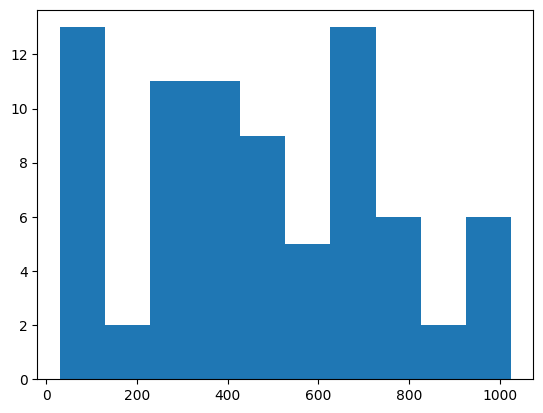

In [ ]:
# Error Yolo
plt.hist(error_gaussians_truth)
plt.show()

Max error gaussian = 72
Min error gaussian = 14


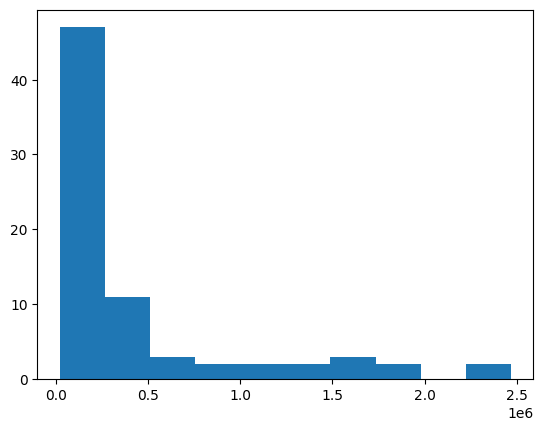

In [ ]:
# Error Yolo
plt.hist(error_gaussians_yolo)

# Gaussian min / max error
print(f'Max error gaussian = {np.argmax(np.array(error_gaussians_yolo))}')
print(f'Min error gaussian = {np.argmin(np.array(error_gaussians_yolo))}')

Max error gaussian = 70
Min error gaussian = 27


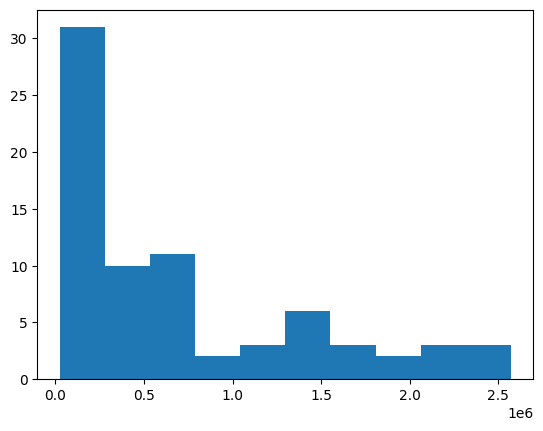

In [ ]:
# Error PX
plt.hist(error_gaussians_px)

# Gaussian min / max error
print(f'Max error gaussian = {np.argmax(np.array(error_gaussians_px))}')
print(f'Min error gaussian = {np.argmin(np.array(error_gaussians_px))}')

In [ ]:
# Important: when covariance/center changes, the region being evaluated will change, this should happend?
# I think so, as the Gaussian estimated need to be compared to the exact location in the image that it was estimated
# Is it possible in any circunstance the error be lower because of the treatd region?

#### [Study] Creating the means and covariances of the mixed models

In [ ]:
all_gaussians_ensembled = ppl_ensemble_predict_gaussians(n_image,
                                      mat_data = mat,
                                      estimation_method = ["YOLO", "YOLO_px"],
                                      peak_method = None,
                                      image_path = image_path,
                                      yolo_model = model,
                                      print_bettersecond = True)


0: 640x256 74 gaussians, 303.2ms
Speed: 2.2ms preprocess, 303.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 235.4ms
Speed: 1.9ms preprocess, 235.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[4, 5, 13, 27, 37, 68]


In [ ]:
# Generates gaussian
generated_z_ensembled_2 = sum_gaussians(image[0], # x
                                      image[1], # y
                                      all_gaussians_ensembled)

In [ ]:
# Error of the ensemble
(all_gaussians_ensembled,
generated_z_ensembled,
rmsep_ensembled,
error_gaussians_ensembled) = compute_error_per_gaussian(image,
                                  [i[0] for i in all_gaussians_ensembled],
                                  list(np.array([i[1] for i in
                                                all_gaussians_ensembled])/2),
                                  [i[2] for i in all_gaussians_ensembled])

In [ ]:
# Comparing errors - Problem is the error is lower in the context in the method
pd.DataFrame([error_gaussians_yolo, error_gaussians_px, error_gaussians_ensembled_2]).T

0             1             2
0   4.544691e+04  1.613277e+05  4.544691e+04
1   5.280561e+04  1.684567e+05  5.654977e+04
2   2.537606e+04  3.439260e+04  2.645817e+04
3   4.031923e+04  9.394205e+04  4.031752e+04
4   4.501023e+04  2.715165e+04  2.655403e+04
..           ...           ...           ...
69  1.071002e+05  1.215624e+05  1.070769e+05
70  1.545039e+06  2.570100e+06  1.545039e+06
71  1.752819e+06  2.362264e+06  2.325127e+06
72  2.468326e+06  1.868154e+06  2.579802e+06
73  2.295203e+05  4.238663e+05  2.295202e+05

[74 rows x 3 columns]

### Error evaluation ensemble Yolo and PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[738, 777, 650, 772, 703, 704, 726, 710, 601, 622, 664, 694, 690, 700, 605, 719, 614, 603, 766, 714]


In [ ]:
# Image path for error_estimation should be the folder of images
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - ensembled method
results = {'Image' : [],
           'Number identified - ensembled' : [],
           'Number identifiable - ensembled' : [],
           'Percentage - ensembled' : [],
           'RMSE_cx - ensembled' : [],
           'RMSE_cy - ensembled' : [],
           'RMSE_c - ensembled' : [],
           'RMSE_sigmax - ensembled' : [],
           'RMSE_sigmay - ensembled' : [],
           'RMSE_sigma - ensembled' : [],
           'MaxE_sigmax - ensembled': [],
           'MaxE_sigmay - ensembled': [],
           'MaxE_sigma - ensembled': [],
           'RMSE_amplitude - ensembled': [],
           'RMSEPixel - ensembled': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       image_path = image_path,
                                       peak_method = 'laplace',
                                       yolo_model = model,
                                       estimation_method = ["YOLO", "YOLO_px"],
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 78 gaussians, 226.0ms
Speed: 1.6ms preprocess, 226.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 175.6ms
Speed: 3.2ms preprocess, 175.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.027097           0]
  [          0    0.013563]]]
covariances true [[[   0.025709           0]
  [          0    0.013859]]]



0: 640x256 81 gaussians, 181.6ms
Speed: 1.2ms preprocess, 181.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 179.1ms
Speed: 1.5ms preprocess, 179.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027385           0]
  [          0    0.014418]]]
covariances true [[[   0.026342           0]
  [          0    0.014722]]]



0: 640x256 79 gaussians, 176.7ms
Speed: 3.1ms preprocess, 176.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 183.8ms
Speed: 1.2ms preprocess, 183.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028106           0]
  [          0    0.014089]]]
covariances true [[[   0.028893           0]
  [          0    0.013613]]]



0: 640x256 77 gaussians, 170.2ms
Speed: 1.8ms preprocess, 170.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 182.4ms
Speed: 1.0ms preprocess, 182.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.027477           0]
  [          0    0.014942]]]
covariances true [[[   0.026338           0]
  [          0    0.014706]]]



0: 640x256 79 gaussians, 174.0ms
Speed: 2.6ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 179.0ms
Speed: 1.3ms preprocess, 179.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019863           0]
  [          0    0.013598]]]
covariances true [[[   0.024871           0]
  [          0    0.013338]]]



0: 640x256 79 gaussians, 179.6ms
Speed: 3.0ms preprocess, 179.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 176.6ms
Speed: 1.3ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.022204           0]
  [          0    0.014646]]]
covariances true [[[   0.026967           0]
  [          0    0.014712]]]



0: 640x256 79 gaussians, 181.0ms
Speed: 3.6ms preprocess, 181.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 177.7ms
Speed: 2.2ms preprocess, 177.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029166           0]
  [          0    0.014775]]]
covariances true [[[   0.028546           0]
  [          0    0.015468]]]



0: 640x256 80 gaussians, 237.4ms
Speed: 1.1ms preprocess, 237.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 264.4ms
Speed: 1.6ms preprocess, 264.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021174           0]
  [          0    0.013209]]]
covariances true [[[   0.026111           0]
  [          0    0.013102]]]



0: 640x256 77 gaussians, 249.2ms
Speed: 1.3ms preprocess, 249.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 251.7ms
Speed: 1.4ms preprocess, 251.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021093           0]
  [          0    0.013115]]]
covariances true [[[   0.029306           0]
  [          0    0.013158]]]



0: 640x256 80 gaussians, 235.1ms
Speed: 1.2ms preprocess, 235.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 182.2ms
Speed: 1.6ms preprocess, 182.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021547           0]
  [          0     0.01341]]]
covariances true [[[   0.029414           0]
  [          0    0.013297]]]



0: 640x256 78 gaussians, 185.0ms
Speed: 0.9ms preprocess, 185.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 176.6ms
Speed: 1.8ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021494           0]
  [          0    0.013726]]]
covariances true [[[   0.026696           0]
  [          0    0.013155]]]



0: 640x256 78 gaussians, 178.5ms
Speed: 2.7ms preprocess, 178.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 180.8ms
Speed: 4.4ms preprocess, 180.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020683           0]
  [          0    0.014477]]]
covariances true [[[   0.027244           0]
  [          0    0.014346]]]



0: 640x256 75 gaussians, 174.8ms
Speed: 2.5ms preprocess, 174.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 181.5ms
Speed: 3.0ms preprocess, 181.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020754           0]
  [          0    0.014394]]]
covariances true [[[   0.026944           0]
  [          0    0.014774]]]



0: 640x256 81 gaussians, 178.1ms
Speed: 1.5ms preprocess, 178.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 175.0ms
Speed: 1.2ms preprocess, 175.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020411           0]
  [          0    0.013768]]]
covariances true [[[   0.025956           0]
  [          0    0.014246]]]



0: 640x256 79 gaussians, 173.1ms
Speed: 1.2ms preprocess, 173.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 185.0ms
Speed: 1.2ms preprocess, 185.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020054           0]
  [          0    0.014909]]]
covariances true [[[   0.026697           0]
  [          0    0.014919]]]



0: 640x256 81 gaussians, 174.6ms
Speed: 1.2ms preprocess, 174.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 179.0ms
Speed: 1.2ms preprocess, 179.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020998           0]
  [          0    0.015582]]]
covariances true [[[   0.025486           0]
  [          0    0.015243]]]



0: 640x256 78 gaussians, 175.0ms
Speed: 1.7ms preprocess, 175.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 175.1ms
Speed: 1.5ms preprocess, 175.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.026662           0]
  [          0    0.014155]]]
covariances true [[[   0.025318           0]
  [          0     0.01372]]]



0: 640x256 80 gaussians, 173.7ms
Speed: 1.5ms preprocess, 173.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 172.5ms
Speed: 1.3ms preprocess, 172.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021479           0]
  [          0    0.015493]]]
covariances true [[[   0.025979           0]
  [          0    0.015276]]]



0: 640x256 79 gaussians, 259.6ms
Speed: 1.9ms preprocess, 259.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 246.9ms
Speed: 1.3ms preprocess, 246.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.028559           0]
  [          0    0.014599]]]
covariances true [[[   0.027789           0]
  [          0     0.01536]]]



0: 640x256 79 gaussians, 241.5ms
Speed: 1.2ms preprocess, 241.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 245.9ms
Speed: 1.4ms preprocess, 245.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.022105           0]
  [          0    0.014874]]]
covariances true [[[   0.029515           0]
  [          0    0.013938]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean        std         max
Image                                688.60      56.81      777.00
Number identified - ensembled         78.85       1.50       81.00
Number identifiable - ensembled       75.30       1.42       77.00
Percentage - ensembled               104.74       2.27      108.11
RMSE_cx - ensembled                   11.71       0.59       13.22
RMSE_cy - ensembled                    0.35       0.22        1.28
RMSE_c - ensembled                    11.72       0.60       13.28
RMSE_sigmax - ensembled               12.45       0.80       13.80
RMSE_sigmay - ensembled                3.95       0.48        5.27
RMSE_sigma - ensembled                13.08       0.74       14.58
MaxE_sigmax - ensembled               54.53       5.33       65.71
MaxE_sigmay - ensembled               74.32       2.69       79.40
MaxE_sigma - ensembled                92.30       3.69       99.20
RMSE_amplitude - ensembled           101.09       3.58      108.37
RMSEPixel - ensembled            5615851.25  241751.13  6008307.31

In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

Image  Number identified - ensembled  Number identifiable - ensembled  \
8     601                             77                               76   
17    603                             80                               77   
14    605                             79                               76   
16    614                             78                               77   
9     622                             80                               76   
2     650                             79                               74   
10    664                             78                               73   
12    690                             75                               75   
11    694                             78                               74   
13    700                             81                               77   
4     703                             79                               74   
5     704                             79                               74   
7     710                             80                               74   
19    714                             79                               76   
15    719                             81                               76   
6     726                             79                               76   
0     738                             78                               77   
18    766                             79                               74   
3     772                             77                               73   
1     777                             81                               77   

    Percentage - ensembled  RMSE_cx - ensembled  RMSE_cy - ensembled  \
8                   101.32                10.67                 0.28   
17                  103.90                11.30                 0.27   
14                  103.95                11.35                 0.41   
16                  101.30                11.36                 0.34   
9                   105.26                12.33                 0.28   
2                   106.76                11.72                 0.27   
10                  106.85                11.80                 0.25   
12                  100.00                12.24                 0.27   
11                  105.41                12.49                 0.25   
13                  105.19                11.50                 0.31   
4                   106.76                11.67                 0.33   
5                   106.76                12.26                 0.34   
7                   108.11                11.25                 0.31   
19                  103.95                13.22                 1.28   
15                  106.58                11.45                 0.33   
6                   103.95                11.63                 0.32   
0                   101.30                12.01                 0.32   
18                  106.76                11.74                 0.27   
3                   105.48                10.87                 0.27   
1                   105.19                11.40                 0.28   

    RMSE_c - ensembled  RMSE_sigmax - ensembled  RMSE_sigmay - ensembled  \
8                10.68                    10.41                     4.03   
17               11.30                    12.63                     3.19   
14               11.36                    11.64                     3.90   
16               11.37                    11.60                     3.64   
9                12.33                    13.45                     3.44   
2                11.72                    13.61                     3.84   
10               11.81                    12.82                     3.71   
12               12.24                    12.30                     4.54   
11               12.50                    12.53                     3.84   
13               11.50                    12.54                     4.22   
4                11.68               

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E4YOLOENSEBPX")

### Error evaluation ensemble Yolo and PX - infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[738, 777, 650, 772, 703, 704, 726, 710, 601, 622, 664, 694, 690, 700, 605, 719, 614, 603, 766, 714]


In [ ]:
# Image path for error_estimation should be the folder of images
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - ensembled method
results = {'Image' : [],
           'Number identified - ensembled' : [],
           'Number identifiable - ensembled' : [],
           'Percentage - ensembled' : [],
           'RMSE_cx - ensembled' : [],
           'RMSE_cy - ensembled' : [],
           'RMSE_c - ensembled' : [],
           'RMSE_sigmax - ensembled' : [],
           'RMSE_sigmay - ensembled' : [],
           'RMSE_sigma - ensembled' : [],
           'MaxE_sigmax - ensembled': [],
           'MaxE_sigmay - ensembled': [],
           'MaxE_sigma - ensembled': [],
           'RMSE_amplitude - ensembled': [],
           'RMSEPixel - ensembled': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       image_path = image_path,
                                       peak_method = 'laplace',
                                       yolo_model = model,
                                       estimation_method = ["YOLO", "YOLO_px_infer"],
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 78 gaussians, 189.1ms
Speed: 1.6ms preprocess, 189.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 178.7ms
Speed: 1.6ms preprocess, 178.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.027097           0]
  [          0    0.013563]]]
covariances true [[[   0.025709           0]
  [          0    0.013859]]]



0: 640x256 81 gaussians, 176.7ms
Speed: 1.1ms preprocess, 176.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 190.6ms
Speed: 1.5ms preprocess, 190.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.027385           0]
  [          0    0.014418]]]
covariances true [[[   0.026342           0]
  [          0    0.014722]]]



0: 640x256 79 gaussians, 203.2ms
Speed: 1.4ms preprocess, 203.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 187.2ms
Speed: 1.3ms preprocess, 187.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028106           0]
  [          0    0.014089]]]
covariances true [[[   0.028893           0]
  [          0    0.013613]]]



0: 640x256 77 gaussians, 175.6ms
Speed: 1.1ms preprocess, 175.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 185.9ms
Speed: 1.1ms preprocess, 185.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.027477           0]
  [          0    0.014942]]]
covariances true [[[   0.026338           0]
  [          0    0.014706]]]



0: 640x256 79 gaussians, 252.7ms
Speed: 2.0ms preprocess, 252.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 518.3ms
Speed: 1.3ms preprocess, 518.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019863           0]
  [          0    0.013598]]]
covariances true [[[   0.024871           0]
  [          0    0.013338]]]



0: 640x256 79 gaussians, 431.2ms
Speed: 1.3ms preprocess, 431.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 263.9ms
Speed: 1.9ms preprocess, 263.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.022204           0]
  [          0    0.014646]]]
covariances true [[[   0.026967           0]
  [          0    0.014712]]]



0: 640x256 79 gaussians, 493.9ms
Speed: 7.4ms preprocess, 493.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 560.2ms
Speed: 8.7ms preprocess, 560.2ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029166           0]
  [          0    0.014775]]]
covariances true [[[   0.028546           0]
  [          0    0.015468]]]



0: 640x256 80 gaussians, 252.4ms
Speed: 1.6ms preprocess, 252.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 258.1ms
Speed: 1.5ms preprocess, 258.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021174           0]
  [          0    0.013209]]]
covariances true [[[   0.026111           0]
  [          0    0.013102]]]



0: 640x256 77 gaussians, 179.8ms
Speed: 1.9ms preprocess, 179.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 182.1ms
Speed: 2.3ms preprocess, 182.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021093           0]
  [          0    0.013115]]]
covariances true [[[   0.029306           0]
  [          0    0.013158]]]



0: 640x256 80 gaussians, 183.9ms
Speed: 1.7ms preprocess, 183.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 180.1ms
Speed: 1.1ms preprocess, 180.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021547           0]
  [          0     0.01341]]]
covariances true [[[   0.029414           0]
  [          0    0.013297]]]



0: 640x256 78 gaussians, 183.1ms
Speed: 1.5ms preprocess, 183.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 183.6ms
Speed: 1.1ms preprocess, 183.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021494           0]
  [          0    0.013726]]]
covariances true [[[   0.026696           0]
  [          0    0.013155]]]



0: 640x256 78 gaussians, 184.4ms
Speed: 1.6ms preprocess, 184.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 221.3ms
Speed: 1.2ms preprocess, 221.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020683           0]
  [          0    0.014477]]]
covariances true [[[   0.027244           0]
  [          0    0.014346]]]



0: 640x256 75 gaussians, 251.3ms
Speed: 1.3ms preprocess, 251.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 247.0ms
Speed: 1.3ms preprocess, 247.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020754           0]
  [          0    0.014394]]]
covariances true [[[   0.026944           0]
  [          0    0.014774]]]



0: 640x256 81 gaussians, 237.5ms
Speed: 1.2ms preprocess, 237.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 251.1ms
Speed: 3.0ms preprocess, 251.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020411           0]
  [          0    0.013768]]]
covariances true [[[   0.025956           0]
  [          0    0.014246]]]



0: 640x256 79 gaussians, 175.8ms
Speed: 1.2ms preprocess, 175.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 187.4ms
Speed: 1.2ms preprocess, 187.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020054           0]
  [          0    0.014909]]]
covariances true [[[   0.026697           0]
  [          0    0.014919]]]



0: 640x256 81 gaussians, 172.8ms
Speed: 1.4ms preprocess, 172.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 182.8ms
Speed: 1.1ms preprocess, 182.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020998           0]
  [          0    0.015582]]]
covariances true [[[   0.025486           0]
  [          0    0.015243]]]



0: 640x256 78 gaussians, 180.3ms
Speed: 1.4ms preprocess, 180.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 176.5ms
Speed: 1.9ms preprocess, 176.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.026662           0]
  [          0    0.014155]]]
covariances true [[[   0.025318           0]
  [          0     0.01372]]]



0: 640x256 80 gaussians, 178.0ms
Speed: 4.0ms preprocess, 178.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 177.1ms
Speed: 1.3ms preprocess, 177.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021479           0]
  [          0    0.015493]]]
covariances true [[[   0.025979           0]
  [          0    0.015276]]]



0: 640x256 79 gaussians, 174.1ms
Speed: 1.3ms preprocess, 174.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 173.5ms
Speed: 3.5ms preprocess, 173.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.028559           0]
  [          0    0.014599]]]
covariances true [[[   0.027789           0]
  [          0     0.01536]]]



0: 640x256 79 gaussians, 178.4ms
Speed: 2.6ms preprocess, 178.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 190.1ms
Speed: 1.3ms preprocess, 190.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.022105           0]
  [          0    0.014874]]]
covariances true [[[   0.029515           0]
  [          0    0.013938]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean        std         max
Image                                688.60      56.81      777.00
Number identified - ensembled         78.85       1.50       81.00
Number identifiable - ensembled       75.30       1.42       77.00
Percentage - ensembled               104.74       2.27      108.11
RMSE_cx - ensembled                   11.71       0.59       13.22
RMSE_cy - ensembled                    0.35       0.22        1.28
RMSE_c - ensembled                    11.72       0.60       13.28
RMSE_sigmax - ensembled               12.56       0.87       14.17
RMSE_sigmay - ensembled                4.23       0.72        6.29
RMSE_sigma - ensembled                13.27       0.85       14.86
MaxE_sigmax - ensembled               55.35       5.86       65.71
MaxE_sigmay - ensembled               77.79      13.24      132.29
MaxE_sigma - ensembled                95.84      11.68      141.85
RMSE_amplitude - ensembled           101.12       3.61      108.37
RMSEPixel - ensembled            5622384.40  245710.83  6085571.56

In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

Image  Number identified - ensembled  Number identifiable - ensembled  \
8     601                             77                               76   
17    603                             80                               77   
14    605                             79                               76   
16    614                             78                               77   
9     622                             80                               76   
2     650                             79                               74   
10    664                             78                               73   
12    690                             75                               75   
11    694                             78                               74   
13    700                             81                               77   
4     703                             79                               74   
5     704                             79                               74   
7     710                             80                               74   
19    714                             79                               76   
15    719                             81                               76   
6     726                             79                               76   
0     738                             78                               77   
18    766                             79                               74   
3     772                             77                               73   
1     777                             81                               77   

    Percentage - ensembled  RMSE_cx - ensembled  RMSE_cy - ensembled  \
8                   101.32                10.67                 0.28   
17                  103.90                11.30                 0.27   
14                  103.95                11.33                 0.37   
16                  101.30                11.36                 0.34   
9                   105.26                12.32                 0.28   
2                   106.76                11.72                 0.27   
10                  106.85                11.79                 0.25   
12                  100.00                12.24                 0.25   
11                  105.41                12.49                 0.25   
13                  105.19                11.48                 0.31   
4                   106.76                11.69                 0.32   
5                   106.76                12.26                 0.34   
7                   108.11                11.26                 0.32   
19                  103.95                13.22                 1.28   
15                  106.58                11.45                 0.33   
6                   103.95                11.61                 0.34   
0                   101.30                12.01                 0.32   
18                  106.76                11.74                 0.27   
3                   105.48                10.87                 0.27   
1                   105.19                11.40                 0.28   

    RMSE_c - ensembled  RMSE_sigmax - ensembled  RMSE_sigmay - ensembled  \
8                10.68                    10.41                     4.03   
17               11.30                    12.63                     3.19   
14               11.34                    12.16                     4.87   
16               11.37                    11.60                     3.64   
9                12.32                    14.17                     4.47   
2                11.72                    13.61                     3.84   
10               11.79                    12.94                     4.25   
12               12.25                    12.64                     6.29   
11               12.50                    12.53                     3.84   
13               11.49                    12.42                     4.74   
4                11.69               

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E4YOLOENSEBPXINFER")

## Whole image generate - plotting ensemble

In [ ]:
# Load data
n_image = 609

# Image - z intensities
image = [x,
         y,
         mat['F_data'][:,:, n_image]]

image_ranges = [(0, 0.143),
                (0, 0.377)]
image_size = [143, 377]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'],
                                    n_image)

In [ ]:
# Predict Yolo
labels_type = "Labelsv0_detect"
task = "detect"
model_name = "YOLOv0_E4_detect"
date_train = "2023-08-21_14-37-58"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

(means,
 covariances,
 amplitudes_yolo) = ppl_yolo_predict_gaussians(mat,
                                               n_image,
                                               model,
                                               image_path,
                                               image_ranges = image_ranges,
                                               image_size = image_size)


0: 640x256 81 gaussians, 197.8ms
Speed: 2.5ms preprocess, 197.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means_infer,
new_covariances_infer,
amplitudes_px_infer,
new_means_infer,
new_covariances_up_infer,
new_covariances_down_infer) = ppl_yolo_px_predict_gaussians(mat,
                                                            n_image,
                                                            model,
                                                            image_path,
                                                            px_step_size = 3,
                                                            infer_overlapping = True)


0: 640x256 81 gaussians, 176.4ms
Speed: 1.4ms preprocess, 176.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [np.array([[(wx/(np.sqrt(2)))**2, 0],
                               [0, (wy/(np.sqrt(2)))**2]]) for
                     wx, wy in zip(dispersion_x, dispersion_y)]
amplitudes_truth = amplitude
(all_gaussians_truth,
 generated_z_truth,
 rmsep_truth,
 error_gaussians_truth) = compute_error_per_gaussian(image,
                                                     means_truth,
                                                     covariances_truth,
                                                     amplitudes_truth)

Gaussian 31 center is out of bounds
Gaussian 73 center is out of bounds
Gaussian 76 center is out of bounds


In [ ]:
# Compute YOLO
(all_gaussians_yolo,
 generated_z_yolo,
 rmsep_yolo,
 error_gaussians_yolo) = compute_error_per_gaussian(image,
                                                    means,
                                                    list(covariances/2),
                                                    amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(all_gaussians_px,
 generated_z_px,
 rmsep_px,
 error_gaussians_px) = compute_error_per_gaussian(image,
                                                  converted_new_means_infer,
                                                  list(new_covariances_infer/2),
                                                  amplitudes_px_infer)

In [ ]:
all_gaussians_ensembled = ppl_ensemble_predict_gaussians(n_image,
                                      mat_data = mat,
                                      estimation_method = ["YOLO", "YOLO_px_infer"],
                                      peak_method = None,
                                      image_path = image_path,
                                      yolo_model = model,
                                      print_bettersecond = True)


0: 640x256 81 gaussians, 270.6ms
Speed: 3.3ms preprocess, 270.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 235.5ms
Speed: 1.5ms preprocess, 235.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[]


In [ ]:
# Error of the ensemble
(all_gaussians_ensembled,
generated_z_ensembled,
rmsep_ensembled,
error_gaussians_ensembled) = compute_error_per_gaussian(image,
                                  [i[0] for i in all_gaussians_ensembled],
                                  list(np.array([i[1] for i in
                                                all_gaussians_ensembled])/2),
                                  [i[2] for i in all_gaussians_ensembled])

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 4, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x,
               y,
               image[2],
               colorbar = False,
               ax = ax[0])

In [ ]:
# Yolo Image
plot_grayscale(x,
               y,
               generated_z_yolo,
               colorbar = False,
               ax = ax[2])
ax[2].set_xlabel("x - YOLO")

Text(0.5, 0, 'x - YOLO')

In [ ]:
# PX image
plot_grayscale(x,
               y,
               generated_z_px,
               colorbar = False,
               ax = ax[3])
ax[3].set_xlabel("x - PX Infer")

Text(0.5, 0, 'x - PX Infer')

In [ ]:
# PX image
plot_grayscale(x,
               y,
               generated_z_ensembled,
               colorbar = False,
               ax = ax[1])
ax[1].set_xlabel("x - Ensembled")

Text(0.5, 0, 'x - Ensembled')

In [ ]:
# Distance of axis
fig.subplots_adjust(wspace= 0.1)

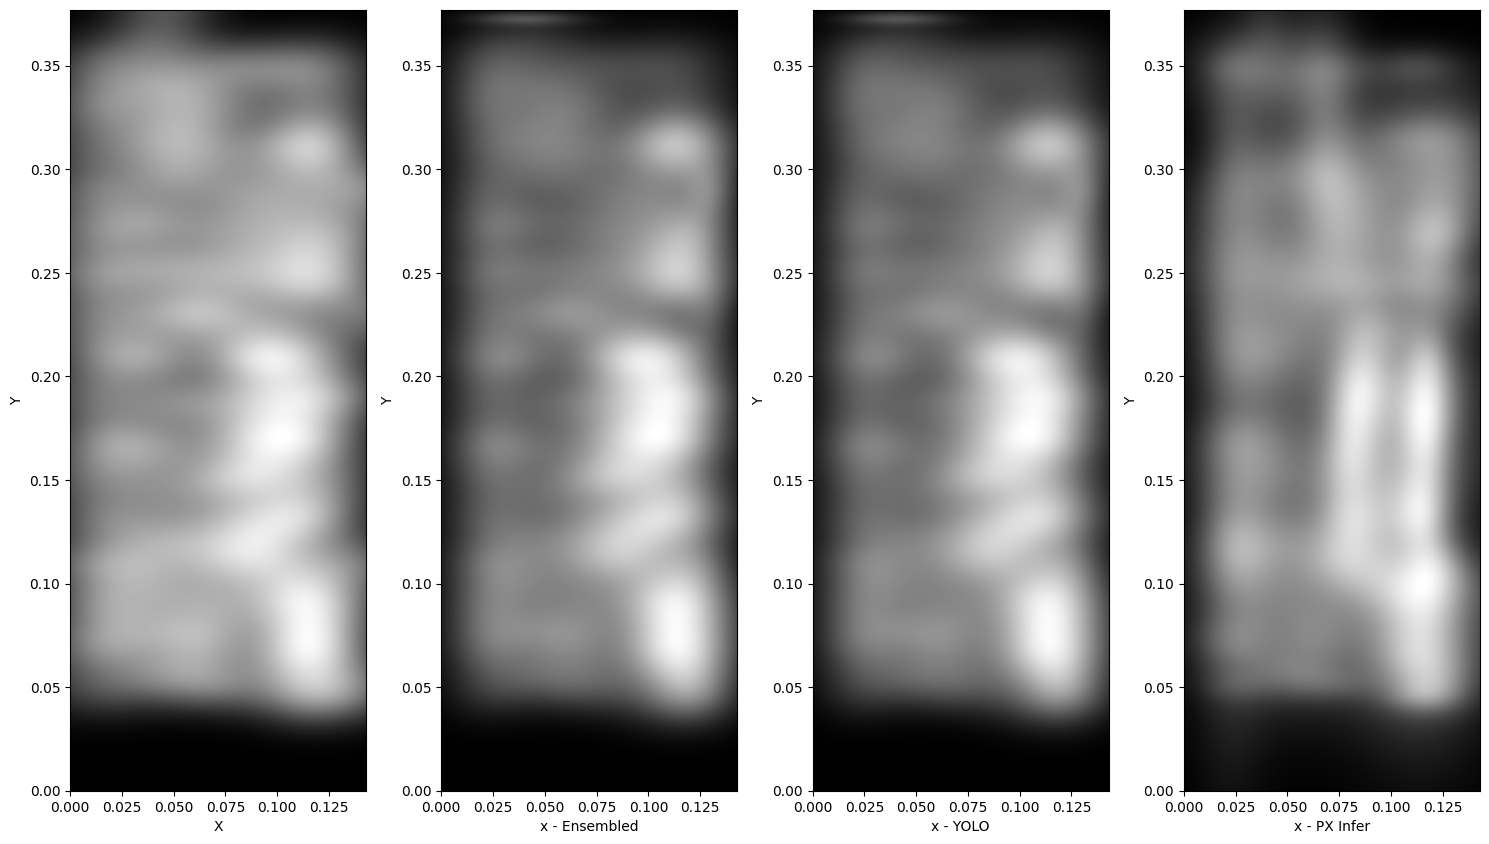

In [ ]:
plt.ion()
plt.tight_layout()
plt.show()

###### Subregion by Gaussian plotting

In [ ]:
n_gaussian = 30
center = all_gaussians[n_gaussian][0]
covariance = all_gaussians[n_gaussian][1]
# Extract region - reconstructed with true one
sub_region = extract_region(generated_z,
                            center,
                            covariance,
                            return_cropped = False)
# Extract region - true one
sub_region_truth = extract_region(image[2],
                                  center,
                                  covariance,
                                  return_cropped = False)

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x,
               y,
               sub_region,
               colorbar = False,
               ax = ax[0])

In [ ]:
# Original image
plot_grayscale(x,
               y,
               sub_region_truth,
               colorbar = False,
               ax = ax[1])

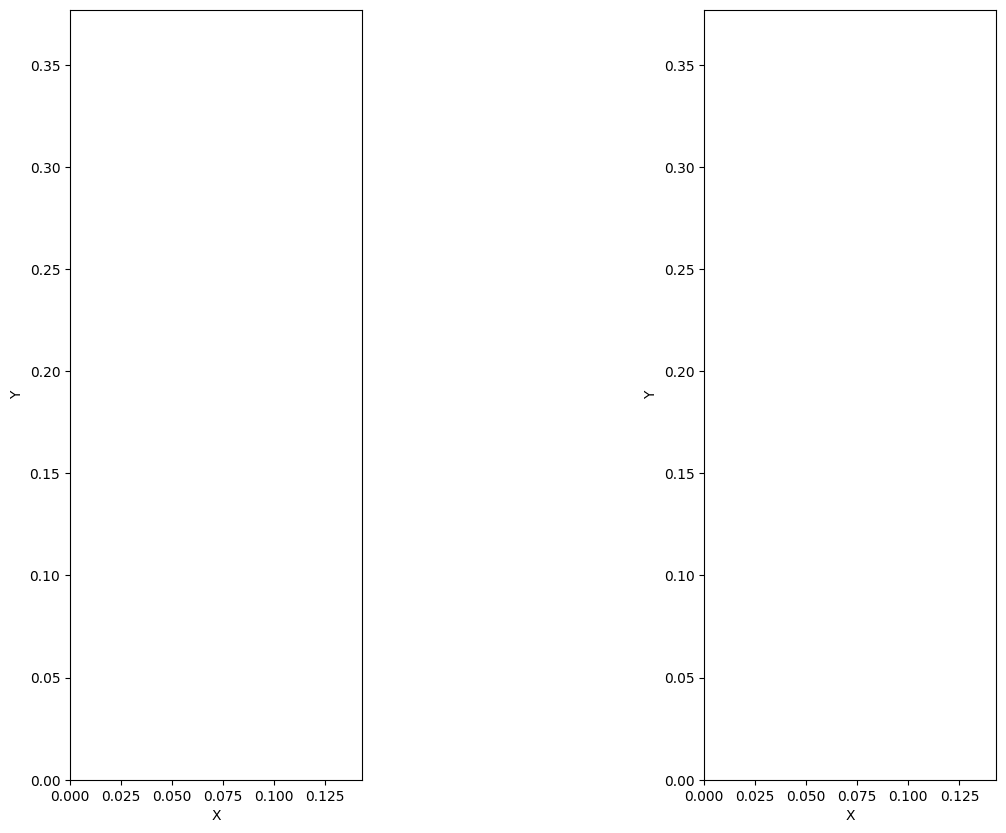

In [ ]:
plt.ion()
plt.show()

###### Cropped region by gaussian plotting

In [ ]:
# Matches Gaussians
row_ind, col_ind = match_gaussians([gaussian[0] for gaussian in all_gaussians_yolo],
                                   list(zip(xs, ys)))

In [ ]:
n_gaussian = 72
n_gaussian_truth = col_ind[np.where(row_ind == n_gaussian)[0]][0]

# YOLO
center = all_gaussians_yolo[n_gaussian][0]
covariance = all_gaussians_yolo[n_gaussian][1]
# Extract region - reconstructed with true one
(sub_region,
 cropped_region,
 _) = extract_region(generated_z_yolo,
                     center,
                     covariance,
                     return_cropped = True)

# Extract region - true one
(sub_region_truth,
 cropped_region_truth,
 region_limits) = extract_region(image[2],
                                 center,
                                 covariance,
                                 return_cropped = True)
# PX
center = all_gaussians_px[n_gaussian][0]
covariance = all_gaussians_px[n_gaussian][1]
# Extract region - reconstructed with true one
(sub_region_px,
 cropped_region_px,
 _) = extract_region(generated_z_px,
                     center,
                     covariance,
                     return_cropped = True)

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               y[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               cropped_region_truth,
               colorbar = True,
               ax = ax[0, 0])
ax[0, 0].set_title('Ground truth')

# Plot updated centers
ax[0, 0].scatter(xs[n_gaussian_truth],
              ys[n_gaussian_truth],
              s = 3, c = 'green')

In [ ]:
# YOLO image
plot_grayscale(x[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               y[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               cropped_region,
               colorbar = True,
               ax = ax[0, 1])
ax[0, 1].set_title('Yolo prediction')

# Plot updated centers
ax[0, 1].scatter(np.array(means)[:, 0][n_gaussian],
              np.array(means)[:, 1][n_gaussian],
              s = 3, c = 'red')

In [ ]:
# Original image
plot_grayscale(x[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               y[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               cropped_region,
               colorbar = True,
               ax = ax[1, 0])
ax[1, 0].set_title('PX prediction')

# Plot updated centers
ax[1, 0].scatter(np.array(means)[:, 0][n_gaussian],
              np.array(means)[:, 1][n_gaussian],
              s = 3, c = 'red')

In [ ]:
ax[1, 1].axis('off')

(0.0, 1.0, 0.0, 1.0)

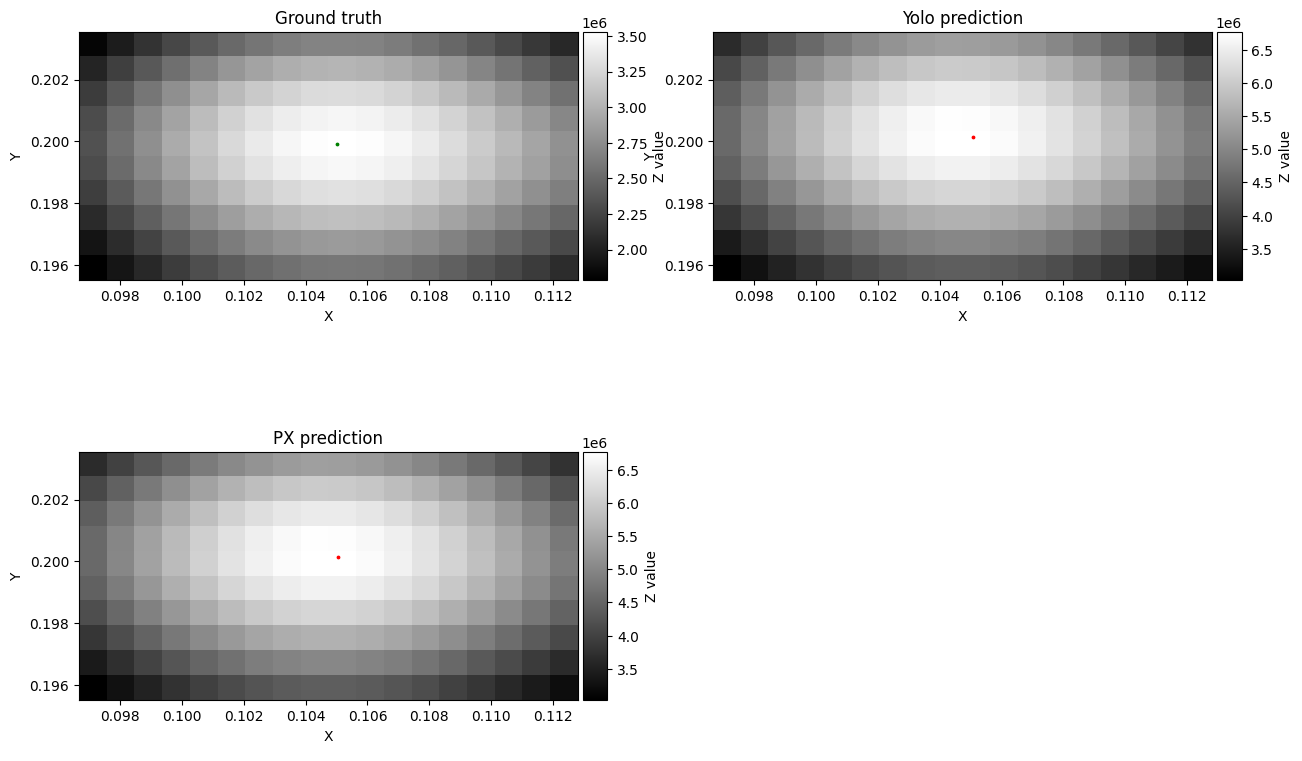

In [ ]:
plt.ion()
plt.show()

#### Evaluate new centers gaussian - NOT Done

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

#### Evaluate new centers yolo

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# YOLO Check covariance and center are ok
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
task = "detect"
model_name = "YOLOv0_detect"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/2023-07-26_18-50-24/{task}/train/weights/best.pt")

# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = image_ranges,
                                          image_size = image_size)

# Plot box and center
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in means],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(covariances[:, 0, 0]),
                                       np.sqrt(covariances[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b',
                                  annotate_gaussians = True,
                                  text_color = 'blue')


0: 640x256 74 gaussians, 307.3ms
Speed: 1.1ms preprocess, 307.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# n_gaussian_tocheck = 43
# ax.scatter(np.array(means)[n_gaussian_tocheck, 0], np.array(means)[n_gaussian_tocheck, 1], s = 3, c = 'red')

In [ ]:
# Plot box and center
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g',
                                        center_color = 'g',
                                        annotate_gaussians = True)

In [ ]:
# Plot updated centers
ax.scatter(np.array(converted_new_means)[:, 0],
           np.array(converted_new_means)[:, 1],
           s = 3, c = 'red')

In [ ]:
# Use adjust_text to avoid overlapping for all texts
adjust_text(all_texts)

11

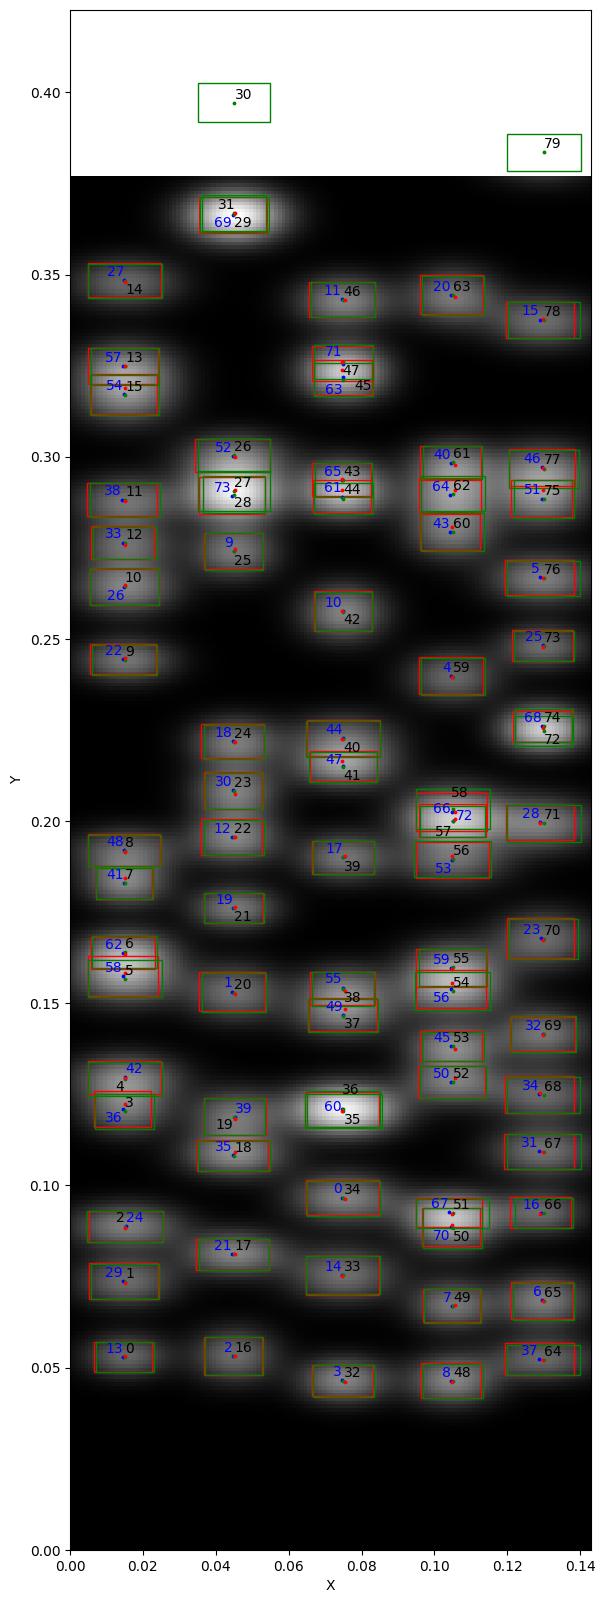

In [ ]:
plt.ion()
plt.show()

## [Estimation] Untangling Gaussians
- When Gaussians sum up in the image, it is not even possible to perfecly identify the centers as one interferes with the other

##### 3D evaluation of region

In [ ]:
# Plot region
n_gaussian_truth = 57
n_gaussian_yolo = 72 # The relation gaussian yolo and true comes from graph

# Center of the image to crop
x_center, y_center = (xs[n_gaussian_truth],
                      ys[n_gaussian_truth])
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian_truth],
                 6 * dispersion_y[n_gaussian_truth])

# Plot points
extra_pts = [{'x': xs[n_gaussian_truth],
              'y': ys[n_gaussian_truth], 'color': 'green'},
             {'x': means[n_gaussian_yolo][0],
              'y': means[n_gaussian_yolo][1], 'color': 'blue'},
             {'x': converted_new_means[n_gaussian_yolo][0],
              'y': converted_new_means[n_gaussian_yolo][1], 'color': 'black'}]

fig = plot_2d_region(image,
               x_center,
               y_center,
               width,
               length,
               colorscale = 'Reds',
               show_points = True,
               annotate = True,
               extra_points = extra_pts)

fig.show()

In [ ]:
# Plot region
n_gaussian = 57
# Center of the image to crop
x_center, y_center = xs[n_gaussian], ys[n_gaussian]
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian],
                 6 * dispersion_y[n_gaussian])
fig = plot_3d_region(image,
                     x_center,
                     y_center,
                     width,
                     length,
                     show_surface = False,
                     colorscale = None,
                     show_points = True,
                     annotate = True)

fig.show()

In [ ]:
# Plot region
n_gaussian = 57
# Center of the image to crop
x_center, y_center = xs[n_gaussian], ys[n_gaussian]
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian],
                 6 * dispersion_y[n_gaussian])
fig = plot_3d_region(image,
                     x_center,
                     y_center,
                     width,
                     length,
                     show_surface = True,
                     colorscale = None,
                     show_points = False,
                     annotate = True)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# First example of convoluted Gaussians
# Plot region
n_gaussian_truth = 57
n_gaussian_yolo = 72 # The relation gaussian yolo and true comes from graph

# Gaussians summed to the 57
n_gaussians_connected = [56, 58, 71]

# Center of the image to crop
x_center, y_center = (xs[n_gaussian_truth],
                      ys[n_gaussian_truth])
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian_truth],
                 6 * dispersion_y[n_gaussian_truth])

# Plot points
extra_pts = [{'x': xs[n_gaussian_truth],
              'y': ys[n_gaussian_truth], 'color': 'green'},
             {'x': means[n_gaussian_yolo][0],
              'y': means[n_gaussian_yolo][1], 'color': 'blue'},
             {'x': converted_new_means[n_gaussian_yolo][0],
              'y': converted_new_means[n_gaussian_yolo][1], 'color': 'black'}]

for n_gaussian_con in n_gaussians_connected:
    extra_pts.append({'x': xs[n_gaussian_con],
                      'y': ys[n_gaussian_con],
                      'color': 'green'})
fig = plot_2d_region(image,
                     x_center,
                     y_center,
                     width,
                     length,
                     colorscale = 'Reds',
                     show_points = True,
                     annotate = True,
                     extra_points = extra_pts)

fig.show()

In [ ]:
# Try using laplacian / derivatives - it may encode the information about the curves not begin "right" because of summing of another Gaussian
# Apriori: Information about local area, number of gaussians and its interferences
# Apriori: Information about gaussians not overlapped, centers and deviation

## Comparison and Sanity check in estimations of GMM, Yolo and truth label
- Clearly sigma x of GMM can be improved
- All covariances before drawing the bounding boxes are multiplied by the sqrt(2)


In [ ]:
# Load data
n_image = 109

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 3, figsize = (15, 10))

In [ ]:
# True labels
# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

means = list(zip(xs, ys))
covariances = list(zip(dispersion_x, dispersion_y))

# Plot box and center
plot_box_labels(image,
                means,
                covariances,
                ax = ax[0])

In [ ]:
,# Estimate GMM - Final prediction
(means,
 covariances,
 angles,
 amplitudes) = ppl_fit_gaussians(image,
                                 means_init = 'laplace',
                                 peak_method = 'laplace',
                                 em_iterations = 1000,
                                 covariance_gaussians_type = 'diag',
                                 n_gaussians = None,
                                 image_ranges = [(0, 0.143), (0, 0.377)],
                                 image_size = [143, 377],
                                 fig_size = (10, 8),
                                 plot = False,
                                 plot_points = False)


# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in zip(np.sqrt(covariances[:, 0, 0]),
                                            np.sqrt(covariances[:, 1, 1]))],
                ax = ax[2])

estimate_parameters_gmm executed in 1.439413070678711 seconds
ppl_fit_gaussians executed in 1.4651055335998535 seconds


In [ ]:
# YOLO Check covariance and center are ok
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
task = "detect"
model_name = "YOLOv0_detect"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/2023-07-26_18-50-24/{task}/train/weights/best.pt")

# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = [(0, 0.143),
                                                          (0, 0.377)],
                                          image_size = [143, 377])

plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax[1])

# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in zip(np.sqrt(covariances[:, 0, 0]),
                                            np.sqrt(covariances[:, 1, 1]))],
                ax = ax[1])


0: 640x256 74 gaussians, 354.9ms
Speed: 2.5ms preprocess, 354.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
np.sqrt(2 * np.log(2))

1.1774100225154747

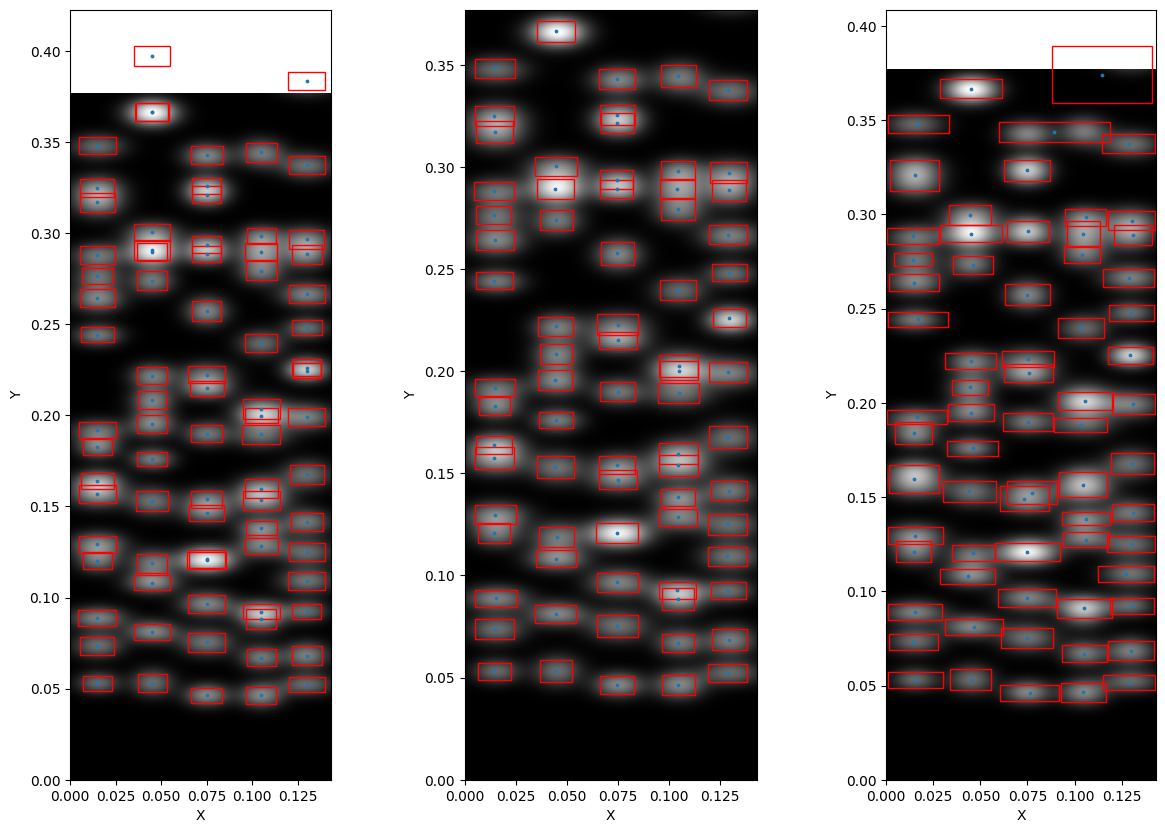

In [ ]:
# show plots
plt.show()
plt.ion()

# Annotations

## SPIDER
- Radius of each hole in the grid is 14 mm (hemsworth1996 - Original NB design);
- Design assumed the beams as two Gaussian parts, core with the 85% power with divergence of 5 mrad and the halo (15% power) with poor divergence of > 15 mrad (hemsworth1996 - Original NB design);
- Expected core beamlet divergence of as low as 2 - 3 mrad (hemsworth1996 - reference 11)

# Pipeline ppl_RNN
- Work of numbers from kaparty
- MASK R-CNN

# Pipeline ppl_CNN
  - Use a CNN to identify the Gaussians
    - Many questions, for example, how to analyse the whole image?
    - Yolo architecture of boxing/training might be a way
  - Check RetinaNet:
    - https://developers.arcgis.com/python/guide/how-retinanet-works/